In [1]:
import pandas as pd
from pathlib import Path
from IPython.display import display
import io
import csv
import math
import missingno as msno
import matplotlib.pyplot as plt
import unicodedata


In [2]:
data_dir = Path("../data/raw")
csv_files = sorted(data_dir.glob("*.csv"))

print(f"{len(csv_files)} fichiers trouves dans {data_dir}:")
for path in csv_files:
    print(f"- {path.name}")


20 fichiers trouves dans ../data/raw:
- 14_EU.csv
- 14_MN14_T1T2.csv
- 17_L_T1.csv
- 17_L_T2.csv
- 17_PR_T1.csv
- 17_PR_T2.csv
- 19_EU.csv
- 20_MN_T1.csv
- 20_MN_T2.csv
- 21_DEP_T1.csv
- 21_DEP_T2.csv
- 21_REG_T1.csv
- 21_REG_T2.csv
- 22_L_T1.csv
- 22_L_T2.csv
- 22_PR_T1.csv
- 22_PR_T2.csv
- 24_EU.csv
- 24_L_T1.csv
- 24_L_T2.csv


In [3]:
dataframes = {}
read_errors = {}
preferred_encoding = {
    "14_EU.csv": "utf-8",
    "14_MN14_T1T2.csv": "utf-8",
    "17_L_T1.csv": "latin-1",
    "17_L_T2.csv": "latin-1",
    "17_PR_T1.csv": "latin-1",
    "17_PR_T2.csv": "latin-1",
    "19_EU.csv": "latin-1",
    "20_MN_T1.csv": "latin-1",
    "20_MN_T2.csv": "latin-1",
    "21_DEP_T1.csv": "latin-1",
    "21_DEP_T2.csv": "latin-1",
    "21_REG_T1.csv": "latin-1",
    "21_REG_T2.csv": "latin-1",
    "22_L_T1.csv": "latin-1",
    "22_L_T2.csv": "utf-8",
    "22_PR_T1.csv": "latin-1",
    "22_PR_T2.csv": "latin-1",
    "24_EU.csv": "utf-8",
    "24_L_T1T2.csv": "utf-8",
    "24_L_T2.csv": "utf-8",
}
fallback_encodings = ["utf-8-sig", "utf-8", "latin-1", "cp1252"]
candidate_block_sizes = {
    "L": 8,
    "PR": 7,
    "EU": 7,
    "MN": 9,
    "DEP": 6,
    "REG": 8,
}

for path in csv_files:
    df = None
    last_exc = None
    used_encoding = None
    column_names = None
    read_kwargs = {"index_col": False}

    try:
        with path.open(encoding="latin-1") as f:
            reader = csv.reader(f, delimiter=";")
            raw_header = next(reader)
            max_fields = len(raw_header)
            for row in reader:
                max_fields = max(max_fields, len(row))
        header_len = len(raw_header)
        parts = path.stem.split("_")
        election_key = parts[1] if len(parts) > 1 else None
        block_len = candidate_block_sizes.get(election_key)
        if block_len:
            base_count = header_len - block_len
            if base_count <= 0:
                raise ValueError("Impossible de determiner le bloc candidat (base <= 0)")
            candidate_count = max(1, math.ceil((max_fields - base_count) / block_len))
            base_cols = raw_header[:base_count]
            candidate_cols = raw_header[base_count:]
            column_names = base_cols.copy()
            for idx in range(candidate_count):
                suffix = idx + 1
                column_names.extend([f"{col} {suffix}" for col in candidate_cols])
            print(
                f"{path.name}: en-tetes etendus a {len(column_names)} colonnes "
                f"({candidate_count} blocs candidat, max {max_fields} champs)."
            )
            read_kwargs.update({"names": column_names, "header": None, "skiprows": 1})
        else:
            read_kwargs.update({"header": 0})
    except Exception as exc:
        print(f"{path.name}: impossible d'etendre les en-tetes ({exc}).")
        read_kwargs.update({"header": 0})

    to_try = []
    if path.name in preferred_encoding:
        to_try.append(preferred_encoding[path.name])
    to_try.extend(enc for enc in fallback_encodings if enc not in to_try)

    for enc in to_try:
        try:
            df = pd.read_csv(
                path,
                sep=";",
                engine="python",
                encoding=enc,
                on_bad_lines="skip",
                **read_kwargs,
            )
            used_encoding = enc
            break
        except (pd.errors.ParserError, UnicodeDecodeError) as exc:
            last_exc = exc
            continue
        except Exception as exc:
            last_exc = exc
            continue

    if df is None:
        read_errors[path.stem] = last_exc
        print(f"Erreur lors de la lecture de {path.name}: {last_exc}")
        continue

    dataframes[path.stem] = df
    print(f"{path.name} charge: {df.shape[0]} lignes, {df.shape[1]} colonnes (encodage {used_encoding})")


14_EU.csv: en-tetes etendus a 13 colonnes (1 blocs candidat, max 13 champs).
14_EU.csv charge: 1656868 lignes, 13 colonnes (encodage utf-8)
14_MN14_T1T2.csv charge: 692029 lignes, 13 colonnes (encodage utf-8)
17_L_T1.csv: en-tetes etendus a 237 colonnes (27 blocs candidat, max 237 champs).
17_L_T1.csv charge: 69242 lignes, 237 colonnes (encodage latin-1)
17_L_T2.csv: en-tetes etendus a 45 colonnes (3 blocs candidat, max 45 champs).
17_L_T2.csv charge: 68767 lignes, 45 colonnes (encodage latin-1)
17_PR_T1.csv: en-tetes etendus a 98 colonnes (11 blocs candidat, max 98 champs).
17_PR_T1.csv charge: 69242 lignes, 98 colonnes (encodage latin-1)
17_PR_T2.csv: en-tetes etendus a 35 colonnes (2 blocs candidat, max 35 champs).
17_PR_T2.csv charge: 69242 lignes, 35 colonnes (encodage latin-1)
19_EU.csv: en-tetes etendus a 257 colonnes (34 blocs candidat, max 257 champs).
19_EU.csv charge: 69297 lignes, 257 colonnes (encodage latin-1)
20_MN_T1.csv: en-tetes etendus a 577 colonnes (1 blocs candida

In [4]:
# Snapshot des colonnes brutes avant harmonisation
if "dataframes" in globals():
    dataframes_raw = {name: df.copy() for name, df in dataframes.items()}
    raw_columns_by_dataset = {name: list(df.columns) for name, df in dataframes.items()}


In [5]:
# Harmonisation des noms de colonnes (avant meta_elections)
import re
import unicodedata

_MOJIBAKE_REPLACEMENTS = {
    "Tï¿½te": "Tête",
    "T�te": "Tête",
    "t�te": "tête",
    "Prï¿½nom": "Prénom",
    "Pr�nom": "Prénom",
    "dï¿½partement": "département",
    "dÃ©partement": "département",
    "d�partement": "département",
    "d�p�t": "dépôt",
    "Bin�me": "Binôme",
    "bin�me": "binôme",
    "Nï¿½": "N°",
    "N�": "N°",
    "ExprimÃ©s": "Exprimés",
    "exprimÃ©s": "exprimés",
    "Exprimï¿½s": "Exprimés",
    "exprimï¿½s": "exprimés",
    "Exprim�s": "Exprimés",
    "exprim�s": "exprimés",
    "Libell�": "Libellé",
    "libell�": "libellé",
    "Abr�g�": "Abrégé",
    "abr�g�": "abrégé",
    "Ã©": "é",
    "Ã¨": "è",
    "Ãª": "ê",
    "Ã«": "ë",
    "Ã ": "à",
    "Ã¢": "â",
    "Ã§": "ç",
    "Ã¹": "ù",
    "Ã»": "û",
    "Ã¯": "ï",
    "Ã´": "ô",
    "Ã¶": "ö",
    "Ã‰": "É",
    "Ãˆ": "È",
    "ÃŠ": "Ê",
    "Ã‹": "Ë",
    "Ã€": "À",
    "Ã‚": "Â",
    "Ã‡": "Ç",
}


def _fix_label(label: str) -> str:
    fixed = label
    try:
        fixed = label.encode("latin1").decode("utf-8")
    except (UnicodeEncodeError, UnicodeDecodeError):
        fixed = label
    for bad, good in _MOJIBAKE_REPLACEMENTS.items():
        if bad in fixed:
            fixed = fixed.replace(bad, good)
    return " ".join(fixed.split())


def _normalize_label_harmon(label: str) -> str:
    fixed = _fix_label(label)
    fixed = re.sub(r"\s*/\s*", "/", fixed)
    fixed = unicodedata.normalize("NFD", fixed)
    fixed = "".join(ch for ch in fixed if unicodedata.category(ch) != "Mn")
    return fixed.lower()


_PERCENT_MAP = {
    "% abstentions": "% Abs/Ins",
    "% blancs/inscrits": "% Blancs/Ins",
    "% blancs/votants": "% Blancs/Vot",
    "% exprimes/inscrits": "% Exp/Ins",
    "% exprimes/votants": "% Exp/Vot",
    "% nuls/inscrits": "% Nuls/Ins",
    "% nuls/votants": "% Nuls/Vot",
}


_HARMONIZE_EXACT = {
    _normalize_label_harmon("% Vot/Ins"): "% Votants",
    _normalize_label_harmon("Code du d°partement"): "Code du département",
    _normalize_label_harmon("Exprim°s"): "Exprimés",
    _normalize_label_harmon("Exprim°s 1"): "Exprimés",
    _normalize_label_harmon("Libell° Abr°g° Liste 1"): "Libellé Abrégé Liste 1",
    _normalize_label_harmon("Libellé abrégé de liste 1"): "Libellé Abrégé Liste 1",
    _normalize_label_harmon("Libell° Etendu Liste 1"): "Libellé Etendu Liste 1",
    _normalize_label_harmon("Liste"): "Libellé Etendu Liste 1",
    _normalize_label_harmon("Libellé de liste 1"): "Libellé Etendu Liste 1",
    _normalize_label_harmon("Liste.1"): "Libellé Etendu Liste 1",
    _normalize_label_harmon("Libell° de la circonscription"): "Libellé de la circonscription",
    _normalize_label_harmon("Libell° de la commune"): "Libellé de la commune",
    _normalize_label_harmon("Libellé commune"): "Libellé de la commune",
    _normalize_label_harmon("Libell° du d°partement"): "Libellé du département",
    _normalize_label_harmon("Libellé département"): "Libellé du département",
    _normalize_label_harmon("Nom candidat 1"): "Nom 1",
    _normalize_label_harmon("Nom Tête de Liste 1"): "Nom 1",
    _normalize_label_harmon("Nom T°te de Liste 1"): "Nom 1",
    _normalize_label_harmon("Nom.1"): "Nom 1",
    _normalize_label_harmon("Pr°nom du candidat 1"): "Prénom 1",
    _normalize_label_harmon("Pr°nom du candidat t°te de liste"): "Prénom 1",
    _normalize_label_harmon("Pr°nom.1"): "Prénom 1",
    _normalize_label_harmon("NÂ°Panneau 1"): "N°Panneau 1",
    _normalize_label_harmon("N.Pan. 1"): "N°Panneau 1",
}



def _harmonize_column(col: str) -> str:
    norm = _normalize_label_harmon(col)
    nums = re.findall(r"\d+", norm)
    first_num = nums[0] if nums else None

    if norm in _PERCENT_MAP:
        return _PERCENT_MAP[norm]

    if norm in _HARMONIZE_EXACT:
        return _HARMONIZE_EXACT[norm]

    if norm in {"n° tour", "nº tour", "no tour"}:
        return "N° tour"

    if norm in {"n°liste", "nliste", "nºliste", "n° liste", "n liste"}:
        return "N°Liste"

    if norm in {"n°panneau", "npanneau", "nºpanneau", "n° panneau", "n panneau"}:
        return "N°Panneau"

    if norm.startswith("n.pan"):
        return f"N°Panneau {first_num}" if first_num else "N°Panneau"

    if norm == "binome":
        return "Binôme"

    if norm == "bv":
        return "Numéro bureau de vote"

    if norm == "code commune":
        return "Code de la commune"

    if norm in {"code du departement", "code departement"}:
        return "Code du département"

    if norm == "numero bureau de vote":
        return "Numéro bureau de vote"

    if re.match(r"^code b\.?vote$", norm) or norm == "code bv" or norm == "code du b.vote":
        return "Numéro bureau de vote"

    if re.match(r"^n[°ºo]? de bureau de vote$", norm):
        return "Numéro bureau de vote"

    if norm.startswith("code nuance"):
        if first_num:
            return f"Code Nuance {first_num}"
        if "candidat" in norm or "liste" in norm:
            return "Code Nuance"

    if re.match(r"^exprimes(?:[\. ]+\d+)?$", norm):
        return "Exprimés"

    if norm.startswith("votants") and first_num:
        return "Votants"

    if norm.startswith("nombre de voix"):
        return f"Voix {first_num}" if first_num else "Voix"

    if "voix/exp" in norm or "voix/exprimes" in norm:
        return f"% Voix/Exp {first_num}" if first_num else "% Voix/Exp"

    if "voix/ins" in norm or "voix/inscrits" in norm:
        return f"% Voix/Ins {first_num}" if first_num else "% Voix/Ins"

    match = re.match(r"^% ?voix/(?:exp|exprime?s)[\. ]?(\d+)$", norm)
    if match:
        return f"% Voix/Exp {match.group(1)}"

    match = re.match(r"^% ?voix/(?:ins|inscrits)[\. ]?(\d+)$", norm)
    if match:
        return f"% Voix/Ins {match.group(1)}"

    if "libell" in norm and "liste" in norm:
        if "abrege" in norm:
            suffix = first_num or "1"
            return f"Libellé Abrégé Liste {suffix}"
        if "etendu" in norm or "de liste" in norm:
            suffix = first_num or "1"
            return f"Libellé Etendu Liste {suffix}"

    if norm.startswith("liste"):
        suffix = first_num or "1"
        return f"Libellé Etendu Liste {suffix}"

    if norm.startswith("n de depot du candidat"):
        return f"N°Panneau {first_num}" if first_num else "N°Panneau"

    if norm.startswith("n de depot de la liste"):
        return f"N°Panneau {first_num}" if first_num else "N°Panneau"

    match = re.match(r"^nom tete de liste(?: (\d+))?$", norm)
    if match:
        suffix = match.group(1) or first_num
        return f"Nom {suffix}" if suffix else "Nom Tête de Liste"

    if norm.startswith("nom du candidat"):
        if first_num:
            return f"Nom {first_num}"
        return "Nom du candidat tête de liste" if "tete de liste" in norm else "Nom du candidat"

    if norm.startswith("nom candidat"):
        return f"Nom {first_num}" if first_num else "Nom du candidat"

    match = re.match(r"^nom[\. ](\d+)$", norm)
    if match:
        return f"Nom {match.group(1)}"

    if norm.startswith("nom") and first_num:
        return f"Nom {first_num}"

    if norm.startswith("nuance liste") or norm.startswith("nuance candidat"):
        return f"Nuance {first_num}" if first_num else "Nuance"

    if norm == "prenom":
        return "Prénom 1"

    if norm.startswith("prenom du candidat") or norm.startswith("prenom candidat"):
        if first_num:
            return f"Prénom {first_num}"
        return "Prénom du candidat tête de liste" if "tete de liste" in norm else "Prénom du candidat"

    match = re.match(r"^prenom[\. ](\d+)$", norm)
    if match:
        return f"Prénom {match.group(1)}"

    if norm.startswith("prenom") and first_num:
        return f"Prénom {first_num}"

    if norm in {"sexe", "sexe candidat"}:
        return "Sexe 1"

    if norm.startswith("sexe candidat") and first_num:
        return f"Sexe {first_num}"

    match = re.match(r"^sexe(?: candidat)?[\. ](\d+)$", norm)
    if match:
        return f"Sexe {match.group(1)}"

    if norm.startswith("sexe") and first_num:
        return f"Sexe {first_num}"

    match = re.match(r"^(?:numero\s+de\s+|n[°ºo]?\s*)?panneau[\. ]?(\d+)$", norm)
    if match:
        return f"N°Panneau {match.group(1)}"

    match = re.match(r"^voix[\. ](\d+)$", norm)
    if match:
        return f"Voix {match.group(1)}"

    return col


def harmonize_columns(df: pd.DataFrame) -> pd.DataFrame:
    rename = {}
    for col in df.columns:
        new_col = _harmonize_column(col)
        if new_col != col:
            rename[col] = new_col
    return df.rename(columns=rename)


In [6]:
for name, df in dataframes.items():
    print(f"=== {name} ===")
    display(df.head())
    info_buf = io.StringIO()
    df.info(buf=info_buf)
    print(info_buf.getvalue())
    print("-" * 80)

if read_errors:
    print("Fichiers en erreur:")
    for name, err in read_errors.items():
        print(f"- {name}: {err}")


=== 14_EU ===


,NÂ° tour,Code dÃ©partement,Code de la commune,Nom de la commune,NÂ° de bureau de vote,Inscrits,Votants 1,ExprimÃ©s 1,NÂ° de dÃ©pÃ´t du candidat 1,Nom du candidat 1,PrÃ©nom du candidat 1,Code nuance du candidat 1,Nombre de voix du candidat 1
0,1,01,1,L'Abergement-Cl�menciat,0001,593,281,262,2,MALEGARIE,Alain,LDIV,0
1,1,01,1,L'Abergement-Cl�menciat,0001,593,281,262,3,GOMEZ,Chantal,LEXG,3
2,1,01,1,L'Abergement-Cl�menciat,0001,593,281,262,4,ARNAUD,Monique,LDIV,1
3,1,01,1,L'Abergement-Cl�menciat,0001,593,281,262,5,ROMANI,Daniel,LDIV,2
4,1,01,1,L'Abergement-Cl�menciat,0001,593,281,262,6,LE PEN,Jean-Marie,LFN,77


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656868 entries, 0 to 1656867
Data columns (total 13 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   NÂ° tour                      1656868 non-null  int64 
 1   Code dÃ©partement             1656868 non-null  object
 2   Code de la commune            1656868 non-null  int64 
 3   Nom de la commune             1656868 non-null  object
 4   NÂ° de bureau de vote         1656868 non-null  object
 5   Inscrits                      1656868 non-null  int64 
 6   Votants 1                     1656868 non-null  int64 
 7   ExprimÃ©s 1                   1656868 non-null  int64 
 8   NÂ° de dÃ©pÃ´t du candidat 1  1656868 non-null  int64 
 9   Nom du candidat 1             1656868 non-null  object
 10  PrÃ©nom du candidat 1         1656868 non-null  object
 11  Code nuance du candidat 1     1656868 non-null  object
 12  Nombre de voix du candidat 1  1656868 non-

,N° tour,Code département,Code commune,Nom de la commune,N° de bureau de vote,Inscrits,Votants,Exprimés,N° de dépôt de la liste,Nom du candidat tête de liste,Prénom du candidat tête de liste,Code nuance de la liste,Nombre de voix
0,1,01,1,L'Abergement-Cl�menciat,0001,599,355,341,4,BOUILLOUX,Delphine,NC,324
1,1,01,1,L'Abergement-Cl�menciat,0001,599,355,341,16,EVALET-TAPONAT,Line,NC,316
2,1,01,1,L'Abergement-Cl�menciat,0001,599,355,341,3,BERAUD,Z�lie,NC,315
3,1,01,1,L'Abergement-Cl�menciat,0001,599,355,341,14,VACLE,Robert,NC,300
4,1,01,1,L'Abergement-Cl�menciat,0001,599,355,341,10,MARGUIN,Jean Paul,NC,276


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692029 entries, 0 to 692028
Data columns (total 13 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   N° tour                            692029 non-null  int64 
 1   Code département                   692029 non-null  object
 2   Code commune                       692029 non-null  int64 
 3   Nom de la commune                  692029 non-null  object
 4   N° de bureau de vote               692029 non-null  object
 5   Inscrits                           692029 non-null  int64 
 6   Votants                            692029 non-null  int64 
 7   Exprimés                           692029 non-null  int64 
 8   N° de dépôt de la liste            692029 non-null  int64 
 9   Nom du candidat tête de liste      692029 non-null  object
 10  Prénom du candidat  tête de liste  692029 non-null  object
 11  Code nuance de la liste            692029 non-null  

,Code du dÃ©partement,LibellÃ© du dÃ©partement,Code de la circonscription,LibellÃ© de la circonscription,Code de la commune,LibellÃ© de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,% Voix/Ins 26,% Voix/Exp 26,NÂ° Panneau 27,Sexe 27,Nom 27,PrÃ©nom 27,Nuance 27,Voix 27,% Voix/Ins 27,% Voix/Exp 27
0,01,Ain,4,4ï¿½me circonscription,1,L'Abergement-Clï¿½menciat,0001,598,261,"43,65",...,None,None,NaN,None,None,None,None,NaN,None,None
1,01,Ain,5,5ï¿½me circonscription,2,L'Abergement-de-Varey,0001,211,79,"37,44",...,None,None,NaN,None,None,None,None,NaN,None,None
2,01,Ain,5,5ï¿½me circonscription,4,Ambï¿½rieu-en-Bugey,0001,1126,637,"56,57",...,None,None,NaN,None,None,None,None,NaN,None,None
3,01,Ain,5,5ï¿½me circonscription,4,Ambï¿½rieu-en-Bugey,0002,1134,579,"51,06",...,None,None,NaN,None,None,None,None,NaN,None,None
4,01,Ain,5,5ï¿½me circonscription,4,Ambï¿½rieu-en-Bugey,0003,1117,560,"50,13",...,None,None,NaN,None,None,None,None,NaN,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69242 entries, 0 to 69241
Columns: 237 entries, Code du dÃ©partement to % Voix/Exp 27
dtypes: float64(48), int64(14), object(175)
memory usage: 125.2+ MB

--------------------------------------------------------------------------------
=== 17_L_T2 ===


,Code du dÃ©partement,LibellÃ© du dÃ©partement,Code de la circonscription,LibellÃ© de la circonscription,Code de la commune,LibellÃ© de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,% Voix/Ins 2,% Voix/Exp 2,NÂ° Panneau 3,Sexe 3,Nom 3,PrÃ©nom 3,Nuance 3,Voix 3,% Voix/Ins 3,% Voix/Exp 3
0,01,Ain,4,4ï¿½me circonscription,1,L'Abergement-Clï¿½menciat,0001,598,290,"48,49",...,"15,38","32,62",NaN,None,None,None,None,NaN,None,None
1,01,Ain,5,5ï¿½me circonscription,2,L'Abergement-de-Varey,0001,209,93,"44,50",...,"14,83","32,63",NaN,None,None,None,None,NaN,None,None
2,01,Ain,5,5ï¿½me circonscription,4,Ambï¿½rieu-en-Bugey,0001,1119,715,"63,90",...,"11,71","35,69",NaN,None,None,None,None,NaN,None,None
3,01,Ain,5,5ï¿½me circonscription,4,Ambï¿½rieu-en-Bugey,0002,1130,685,"60,62",...,"14,69","42,24",NaN,None,None,None,None,NaN,None,None
4,01,Ain,5,5ï¿½me circonscription,4,Ambï¿½rieu-en-Bugey,0003,1115,626,"56,14",...,"14,89","37,90",NaN,None,None,None,None,NaN,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68767 entries, 0 to 68766
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Code du dÃ©partement            68767 non-null  object 
 1   LibellÃ© du dÃ©partement        68767 non-null  object 
 2   Code de la circonscription      68767 non-null  int64  
 3   LibellÃ© de la circonscription  68767 non-null  object 
 4   Code de la commune              68767 non-null  int64  
 5   LibellÃ© de la commune          68767 non-null  object 
 6   Code du b.vote                  68767 non-null  object 
 7   Inscrits                        68767 non-null  int64  
 8   Abstentions                     68767 non-null  int64  
 9   % Abs/Ins                       68767 non-null  object 
 10  Votants                         68767 non-null  int64  
 11  % Vot/Ins                       68767 non-null  object 
 12  Blancs                          

,Code du dÃ©partement,LibellÃ© du dÃ©partement,Code de la circonscription,LibellÃ© de la circonscription,Code de la commune,LibellÃ© de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Voix 10,% Voix/Ins 10,% Voix/Exp 10,NÂ° Panneau 11,Sexe 11,Nom 11,PrÃ©nom 11,Voix 11,% Voix/Ins 11,% Voix/Exp 11
0,01,Ain,4,4ï¿½me circonscription,1,L'Abergement-Clï¿½menciat,0001,598,92,"15,38",...,6,"1,00","1,21",11,M,FILLON,Franï¿½ois,110,"18,39","22,22"
1,01,Ain,5,5ï¿½me circonscription,2,L'Abergement-de-Varey,0001,209,25,"11,96",...,1,"0,48","0,57",11,M,FILLON,Franï¿½ois,34,"16,27","19,32"
2,01,Ain,5,5ï¿½me circonscription,4,Ambï¿½rieu-en-Bugey,0001,1116,233,"20,88",...,7,"0,63","0,81",11,M,FILLON,Franï¿½ois,116,"10,39","13,49"
3,01,Ain,5,5ï¿½me circonscription,4,Ambï¿½rieu-en-Bugey,0002,1128,256,"22,70",...,11,"0,98","1,29",11,M,FILLON,Franï¿½ois,124,"10,99","14,59"
4,01,Ain,5,5ï¿½me circonscription,4,Ambï¿½rieu-en-Bugey,0003,1116,227,"20,34",...,7,"0,63","0,80",11,M,FILLON,Franï¿½ois,149,"13,35","17,05"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69242 entries, 0 to 69241
Data columns (total 98 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Code du dÃ©partement            69242 non-null  object
 1   LibellÃ© du dÃ©partement        69242 non-null  object
 2   Code de la circonscription      69242 non-null  int64 
 3   LibellÃ© de la circonscription  69242 non-null  object
 4   Code de la commune              69242 non-null  int64 
 5   LibellÃ© de la commune          69242 non-null  object
 6   Code du b.vote                  69242 non-null  object
 7   Inscrits                        69242 non-null  int64 
 8   Abstentions                     69242 non-null  int64 
 9   % Abs/Ins                       69242 non-null  object
 10  Votants                         69242 non-null  int64 
 11  % Vot/Ins                       69242 non-null  object
 12  Blancs                          69242 non-null

,Code du dÃ©partement,LibellÃ© du dÃ©partement,Code de la circonscription,Libellï¿½ de la circonscription,Code de la commune,Libellï¿½ de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Voix 1,% Voix/Ins 1,% Voix/Exp 1,Nï¿½Panneau 2,Sexe 2,Nom 2,Prï¿½nom 2,Voix 2,% Voix/Ins 2,% Voix/Exp 2
0,01,Ain,4,4ï¿½me circonscription,1,L'Abergement-Clï¿½menciat,0001,598,100,"16,72",...,272,"45,48","60,04",2,F,LE PEN,Marine,181,"30,27","39,96"
1,01,Ain,5,5ï¿½me circonscription,2,L'Abergement-de-Varey,0001,209,32,"15,31",...,93,"44,50","62,00",2,F,LE PEN,Marine,57,"27,27","38,00"
2,01,Ain,5,5ï¿½me circonscription,4,Ambï¿½rieu-en-Bugey,0001,1116,267,"23,92",...,416,"37,28","56,91",2,F,LE PEN,Marine,315,"28,23","43,09"
3,01,Ain,5,5ï¿½me circonscription,4,Ambï¿½rieu-en-Bugey,0002,1128,286,"25,35",...,429,"38,03","57,89",2,F,LE PEN,Marine,312,"27,66","42,11"
4,01,Ain,5,5ï¿½me circonscription,4,Ambï¿½rieu-en-Bugey,0003,1116,252,"22,58",...,453,"40,59","60,16",2,F,LE PEN,Marine,300,"26,88","39,84"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69242 entries, 0 to 69241
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Code du dÃ©partement             69242 non-null  object
 1   LibellÃ© du dÃ©partement         69242 non-null  object
 2   Code de la circonscription       69242 non-null  int64 
 3   Libellï¿½ de la circonscription  69242 non-null  object
 4   Code de la commune               69242 non-null  int64 
 5   Libellï¿½ de la commune          69242 non-null  object
 6   Code du b.vote                   69242 non-null  object
 7   Inscrits                         69242 non-null  int64 
 8   Abstentions                      69242 non-null  int64 
 9   % Abs/Ins                        69242 non-null  object
 10  Votants                          69242 non-null  int64 
 11  % Vot/Ins                        69242 non-null  object
 12  Blancs                          

,Code du dÃ©partement,LibellÃ© du dÃ©partement,Code de la commune,Libellï¿½ de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,...,Voix 33,% Voix/Ins 33,% Voix/Exp 33,Nï¿½Liste 34,Libellï¿½ Abrï¿½gï¿½ Liste 34,Libellï¿½ Etendu Liste 34,Nom Tï¿½te de Liste 34,Voix 34,% Voix/Ins 34,% Voix/Exp 34
0,01,Ain,1,L'Abergement-Clï¿½menciat,0001,601,268,"44,59",333,"55,41",...,0,"0,00","0,00",34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,0,"0,00","0,00"
1,01,Ain,2,L'Abergement-de-Varey,0001,210,69,"32,86",141,"67,14",...,0,"0,00","0,00",34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,0,"0,00","0,00"
2,01,Ain,4,Ambï¿½rieu-en-Bugey,0001,1050,548,"52,19",502,"47,81",...,0,"0,00","0,00",34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,10,"0,95","2,11"
3,01,Ain,4,Ambï¿½rieu-en-Bugey,0002,1106,527,"47,65",579,"52,35",...,0,"0,00","0,00",34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,8,"0,72","1,48"
4,01,Ain,4,Ambï¿½rieu-en-Bugey,0003,1058,485,"45,84",573,"54,16",...,0,"0,00","0,00",34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,0,"0,00","0,00"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69297 entries, 0 to 69296
Columns: 257 entries, Code du dÃ©partement to % Voix/Exp 34
dtypes: int64(75), object(182)
memory usage: 135.9+ MB

--------------------------------------------------------------------------------
=== 20_MN_T1 ===


,Code du dÃ©partement,LibellÃ© du dÃ©partement,Code de la commune,Libellï¿½ de la commune,Code B.Vote,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,...,% Voix/Exp.60,N.Pan..61 1,Code Nuance.61 1,Sexe.61 1,Nom.61 1,Prï¿½nom.61 1,Liste.61 1,Voix.61 1,% Voix/Ins.61 1,% Voix/Exp.61 1
0,1,Ain,1,L'Abergement-Clï¿½menciat,1,622,340,"54,66",282,"45,34",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Ain,2,L'Abergement-de-Varey,1,212,83,"39,15",129,"60,85",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Ain,4,Ambï¿½rieu-en-Bugey,1,1042,686,"65,83",356,"34,17",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Ain,4,Ambï¿½rieu-en-Bugey,2,1064,722,"67,86",342,"32,14",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Ain,4,Ambï¿½rieu-en-Bugey,3,1120,696,"62,14",424,"37,86",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68941 entries, 0 to 68940
Columns: 577 entries, Code du dÃ©partement to % Voix/Exp.61 1
dtypes: float64(165), int64(8), object(404)
memory usage: 303.5+ MB

--------------------------------------------------------------------------------
=== 20_MN_T2 ===


,Code du département,Libellé du département,Code de la commune,Libellé de la commune,Code B.Vote,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,...,% Voix/Exp 60,N.Pan. 61,Code Nuance 61,Sexe 61,Nom 61,Prénom 61,Liste 61,Voix 61,% Voix/Ins 61,% Voix/Exp 61
0,01,Ain,12,Aranc,0001,273,120,"43,96",153,"56,04",...,None,NaN,None,None,None,None,NaN,NaN,None,None
1,01,Ain,34,Belley,0001,892,422,"47,31",470,"52,69",...,None,NaN,None,None,None,None,NaN,NaN,None,None
2,01,Ain,34,Belley,0002,973,471,"48,41",502,"51,59",...,None,NaN,None,None,None,None,NaN,NaN,None,None
3,01,Ain,34,Belley,0003,967,546,"56,46",421,"43,54",...,None,NaN,None,None,None,None,NaN,NaN,None,None
4,01,Ain,34,Belley,0004,969,491,"50,67",478,"49,33",...,None,NaN,None,None,None,None,NaN,NaN,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19571 entries, 0 to 19570
Columns: 568 entries, Code du département to % Voix/Exp 61
dtypes: float64(176), int64(9), object(383)
memory usage: 84.8+ MB

--------------------------------------------------------------------------------
=== 21_DEP_T1 ===


,Code du département,Libellé du département,Code du canton,Libellé du canton,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Nuance 13,Voix 13,% Voix/Ins 13,% Voix/Exp 13,N°Panneau 14,Binôme 14,Nuance 14,Voix 14,% Voix/Ins 14,% Voix/Exp 14
0,01,Ain,8,Châtillon-sur-Chalaronne,1,L'Abergement-Clémenciat,0001,622,420,"67,52",...,None,NaN,None,None,NaN,None,None,NaN,None,None
1,01,Ain,1,Ambérieu-en-Bugey,2,L'Abergement-de-Varey,0001,208,116,"55,77",...,None,NaN,None,None,NaN,None,None,NaN,None,None
2,01,Ain,1,Ambérieu-en-Bugey,4,Ambérieu-en-Bugey,0001,1060,788,"74,34",...,None,NaN,None,None,NaN,None,None,NaN,None,None
3,01,Ain,1,Ambérieu-en-Bugey,4,Ambérieu-en-Bugey,0002,1096,778,"70,99",...,None,NaN,None,None,NaN,None,None,NaN,None,None
4,01,Ain,1,Ambérieu-en-Bugey,4,Ambérieu-en-Bugey,0003,1137,757,"66,58",...,None,NaN,None,None,NaN,None,None,NaN,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66016 entries, 0 to 66015
Columns: 105 entries, Code du département to % Voix/Exp 14
dtypes: float64(26), int64(10), object(69)
memory usage: 52.9+ MB

--------------------------------------------------------------------------------
=== 21_DEP_T2 ===


,Code du département,Libellé du département,Code du canton,Libellé du canton,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Nuance 2,Voix 2,% Voix/Ins 2,% Voix/Exp 2,N°Panneau 3,Binôme 3,Nuance 3,Voix 3,% Voix/Ins 3,% Voix/Exp 3
0,01,Ain,8,Châtillon-sur-Chalaronne,1,L'Abergement-Clémenciat,0001,622,414,"66,56",...,BC-DIV,81.0,"13,02","41,97",NaN,None,None,NaN,None,None
1,01,Ain,1,Ambérieu-en-Bugey,2,L'Abergement-de-Varey,0001,208,108,"51,92",...,BC-DVD,56.0,"26,92","60,87",NaN,None,None,NaN,None,None
2,01,Ain,1,Ambérieu-en-Bugey,4,Ambérieu-en-Bugey,0001,1062,817,"76,93",...,BC-DVD,142.0,"13,37","61,21",NaN,None,None,NaN,None,None
3,01,Ain,1,Ambérieu-en-Bugey,4,Ambérieu-en-Bugey,0002,1096,793,"72,35",...,BC-DVD,188.0,"17,15","67,14",NaN,None,None,NaN,None,None
4,01,Ain,1,Ambérieu-en-Bugey,4,Ambérieu-en-Bugey,0003,1137,788,"69,31",...,BC-DVD,207.0,"18,21","63,11",NaN,None,None,NaN,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62063 entries, 0 to 62062
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code du département     62063 non-null  object 
 1   Libellé du département  62063 non-null  object 
 2   Code du canton          62063 non-null  int64  
 3   Libellé du canton       62063 non-null  object 
 4   Code de la commune      62063 non-null  int64  
 5   Libellé de la commune   62063 non-null  object 
 6   Code du b.vote          62063 non-null  object 
 7   Inscrits                62063 non-null  int64  
 8   Abstentions             62063 non-null  int64  
 9   % Abs/Ins               62063 non-null  object 
 10  Votants                 62063 non-null  int64  
 11  % Vot/Ins               62063 non-null  object 
 12  Blancs                  62063 non-null  int64  
 13  % Blancs/Ins            62063 non-null  object 
 14  % Blancs/Vot            62063 non-null

,Code du département,Libellé du département,Libellé de la section électorale,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,Votants,...,% Voix/Ins 13,% Voix/Exp 13,N°Liste 14,Nuance Liste 14,Libellé Abrégé Liste 14,Libellé Etendu Liste 14,Nom Tête de Liste 14,Voix 14,% Voix/Ins 14,% Voix/Exp 14
0,01,Ain,Ain,1,L'Abergement-Clémenciat,0001,622,421,"67,68",201,...,None,None,NaN,None,None,None,None,NaN,None,None
1,01,Ain,Ain,2,L'Abergement-de-Varey,0001,208,115,"55,29",93,...,None,None,NaN,None,None,None,None,NaN,None,None
2,01,Ain,Ain,4,Ambérieu-en-Bugey,0001,1060,793,"74,81",267,...,None,None,NaN,None,None,None,None,NaN,None,None
3,01,Ain,Ain,4,Ambérieu-en-Bugey,0002,1096,782,"71,35",314,...,None,None,NaN,None,None,None,None,NaN,None,None
4,01,Ain,Ain,4,Ambérieu-en-Bugey,0003,1137,761,"66,93",376,...,None,None,NaN,None,None,None,None,NaN,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68611 entries, 0 to 68610
Columns: 132 entries, Code du département to % Voix/Exp 14
dtypes: float64(20), int64(15), object(97)
memory usage: 69.1+ MB

--------------------------------------------------------------------------------
=== 21_REG_T2 ===


,Code du département,Libellé du département,Libellé de la section électorale,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,Votants,...,% Voix/Ins 4,% Voix/Exp 4,N°Liste 5,Nuance Liste 5,Libellé Abrégé Liste 5,Libellé Etendu Liste 5,Nom Tête de Liste 5,Voix 5,% Voix/Ins 5,% Voix/Exp 5
0,01,Ain,Ain,1,L'Abergement-Clémenciat,0001,622,414,"66,56",208,...,None,None,NaN,None,None,None,None,NaN,None,None
1,01,Ain,Ain,2,L'Abergement-de-Varey,0001,208,108,"51,92",100,...,None,None,NaN,None,None,None,None,NaN,None,None
2,01,Ain,Ain,4,Ambérieu-en-Bugey,0001,1062,813,"76,55",249,...,None,None,NaN,None,None,None,None,NaN,None,None
3,01,Ain,Ain,4,Ambérieu-en-Bugey,0002,1096,797,"72,72",299,...,None,None,NaN,None,None,None,None,NaN,None,None
4,01,Ain,Ain,4,Ambérieu-en-Bugey,0003,1137,787,"69,22",350,...,None,None,NaN,None,None,None,None,NaN,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68611 entries, 0 to 68610
Data columns (total 60 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Code du département               68611 non-null  object 
 1   Libellé du département            68611 non-null  object 
 2   Libellé de la section électorale  66723 non-null  object 
 3   Code de la commune                68611 non-null  int64  
 4   Libellé de la commune             68611 non-null  object 
 5   Code du b.vote                    68611 non-null  object 
 6   Inscrits                          68611 non-null  int64  
 7   Abstentions                       68611 non-null  int64  
 8   % Abs/Ins                         68611 non-null  object 
 9   Votants                           68611 non-null  int64  
 10  % Vot/Ins                         68611 non-null  object 
 11  Blancs                            68611 non-null  int64  
 12  % Bl

,Code du département,Libellé du département,Code de la circonscription,Libellé de la circonscription,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,% Voix/Ins 21,% Voix/Exp 21,N°Panneau 22,Sexe 22,Nom 22,Prénom 22,Nuance 22,Voix 22,% Voix/Ins 22,% Voix/Exp 22
0,01,Ain,4,4ème circonscription,1,L'Abergement-Clémenciat,0001,644,301,"46,74",...,None,None,NaN,None,None,None,None,NaN,None,None
1,01,Ain,5,5ème circonscription,2,L'Abergement-de-Varey,0001,218,85,"38,99",...,None,None,NaN,None,None,None,None,NaN,None,None
2,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0001,1134,664,"58,55",...,None,None,NaN,None,None,None,None,NaN,None,None
3,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0002,1141,625,"54,78",...,None,None,NaN,None,None,None,None,NaN,None,None
4,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0003,1211,596,"49,22",...,None,None,NaN,None,None,None,None,NaN,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69682 entries, 0 to 69681
Columns: 197 entries, Code du département to % Voix/Exp 22
dtypes: float64(36), int64(16), object(145)
memory usage: 104.7+ MB

--------------------------------------------------------------------------------
=== 22_L_T2 ===


,Code du dï¿½partement,Libellï¿½ du dï¿½partement,Code de la circonscription,Libellï¿½ de la circonscription,Code de la commune,Libellï¿½ de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,% Voix/Ins 2,% Voix/Exp 2,Nï¿½Panneau 3,Sexe 3,Nom 3,Prï¿½nom 3,Nuance 3,Voix 3,% Voix/Ins 3,% Voix/Exp 3
0,01,Ain,4,4�me circonscription,1,L'Abergement-Cl�menciat,0001,644,321,"49,84",...,"26,71","62,77",NaN,None,None,None,None,NaN,None,None
1,01,Ain,5,5�me circonscription,2,L'Abergement-de-Varey,0001,218,84,"38,53",...,"32,57","55,04",NaN,None,None,None,None,NaN,None,None
2,01,Ain,5,5�me circonscription,4,Amb�rieu-en-Bugey,0001,1134,689,"60,76",...,"17,64","49,26",NaN,None,None,None,None,NaN,None,None
3,01,Ain,5,5�me circonscription,4,Amb�rieu-en-Bugey,0002,1141,684,"59,95",...,"20,68","56,46",NaN,None,None,None,None,NaN,None,None
4,01,Ain,5,5�me circonscription,4,Amb�rieu-en-Bugey,0003,1212,645,"53,22",...,"20,71","48,64",NaN,None,None,None,None,NaN,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69355 entries, 0 to 69354
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Code du dï¿½partement            69355 non-null  object 
 1   Libellï¿½ du dï¿½partement       69355 non-null  object 
 2   Code de la circonscription       69355 non-null  int64  
 3   Libellï¿½ de la circonscription  69355 non-null  object 
 4   Code de la commune               69355 non-null  int64  
 5   Libellï¿½ de la commune          69355 non-null  object 
 6   Code du b.vote                   69355 non-null  object 
 7   Inscrits                         69355 non-null  int64  
 8   Abstentions                      69355 non-null  int64  
 9   % Abs/Ins                        69355 non-null  object 
 10  Votants                          69355 non-null  int64  
 11  % Vot/Ins                        69355 non-null  object 
 12  Blancs            

,Code du département,Libellé du département,Code de la circonscription,Libellé de la circonscription,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Voix 11,% Voix/Ins 11,% Voix/Exp 11,N°Panneau 12,Sexe 12,Nom 12,Prénom 12,Voix 12,% Voix/Ins 12,% Voix/Exp 12
0,01,Ain,4,4ème circonscription,1,L'Abergement-Clémenciat,0001,645,108,"16,74",...,3,"0,47","0,58",12,M,DUPONT-AIGNAN,Nicolas,21,"3,26","4,04"
1,01,Ain,5,5ème circonscription,2,L'Abergement-de-Varey,0001,213,38,"17,84",...,3,"1,41","1,75",12,M,DUPONT-AIGNAN,Nicolas,0,"0,00","0,00"
2,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0001,1129,266,"23,56",...,8,"0,71","0,95",12,M,DUPONT-AIGNAN,Nicolas,13,"1,15","1,55"
3,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0002,1128,265,"23,49",...,4,"0,35","0,48",12,M,DUPONT-AIGNAN,Nicolas,20,"1,77","2,38"
4,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0003,1213,246,"20,28",...,3,"0,25","0,32",12,M,DUPONT-AIGNAN,Nicolas,19,"1,57","2,00"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69682 entries, 0 to 69681
Columns: 105 entries, Code du département to % Voix/Exp 12
dtypes: int64(32), object(73)
memory usage: 55.8+ MB

--------------------------------------------------------------------------------
=== 22_PR_T2 ===


,Code du département,Libellé du département,Code de la circonscription,Libellé de la circonscription,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Voix 1,% Voix/Ins 1,% Voix/Exp 1,N°Panneau 2,Sexe 2,Nom 2,Prénom 2,Voix 2,% Voix/Ins 2,% Voix/Exp 2
0,01,Ain,4,4ème circonscription,1,L'Abergement-Clémenciat,0001,643,146,"22,71",...,237,"36,86","52,67",2,F,LE PEN,Marine,213,"33,13","47,33"
1,01,Ain,5,5ème circonscription,2,L'Abergement-de-Varey,0001,213,45,"21,13",...,94,"44,13","66,20",2,F,LE PEN,Marine,48,"22,54","33,80"
2,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0001,1130,322,"28,50",...,360,"31,86","50,35",2,F,LE PEN,Marine,355,"31,42","49,65"
3,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0002,1129,313,"27,72",...,426,"37,73","56,57",2,F,LE PEN,Marine,327,"28,96","43,43"
4,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0003,1213,303,"24,98",...,449,"37,02","55,99",2,F,LE PEN,Marine,353,"29,10","44,01"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69682 entries, 0 to 69681
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Code du département            69682 non-null  object
 1   Libellé du département         69682 non-null  object
 2   Code de la circonscription     69682 non-null  int64 
 3   Libellé de la circonscription  69682 non-null  object
 4   Code de la commune             69682 non-null  int64 
 5   Libellé de la commune          69682 non-null  object
 6   Code du b.vote                 69682 non-null  object
 7   Inscrits                       69682 non-null  int64 
 8   Abstentions                    69682 non-null  int64 
 9   % Abs/Ins                      69682 non-null  object
 10  Votants                        69682 non-null  int64 
 11  % Vot/Ins                      69682 non-null  object
 12  Blancs                         69682 non-null  int64 
 13  %

,Code localisation,LibellÃ© localisation,Code dÃ©partement,LibellÃ© dÃ©partement,Code commune,LibellÃ© commune,Code BV,Inscrits,Votants,% Votants,...,% Voix/exprimÃ©s 37,SiÃ¨ges 37,NumÃ©ro de panneau 38,Nuance liste 38 1,LibellÃ© abrÃ©gÃ© de liste 38 1,LibellÃ© de liste 38 1,Voix 38 1,% Voix/inscrits 38 1,% Voix/exprimÃ©s 38 1,SiÃ¨ges 38 1
0,FE,France entière,01,Ain,01001,L'Abergement-Clémenciat,0001,662,373,"56,34%",...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
1,FE,France entière,01,Ain,01002,L'Abergement-de-Varey,0001,228,156,"68,42%",...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
2,FE,France entière,01,Ain,01004,Ambérieu-en-Bugey,0001,1082,522,"48,24%",...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
3,FE,France entière,01,Ain,01004,Ambérieu-en-Bugey,0002,1077,566,"52,55%",...,"0,36%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
4,FE,France entière,01,Ain,01004,Ambérieu-en-Bugey,0003,1123,640,"56,99%",...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70104 entries, 0 to 70103
Columns: 325 entries, Code localisation to SiÃ¨ges 38 1
dtypes: int64(120), object(205)
memory usage: 173.8+ MB

--------------------------------------------------------------------------------
=== 24_L_T1 ===


,Code dÃ©partement,LibellÃ© dÃ©partement,Code commune,LibellÃ© commune,Code BV,Inscrits,Votants,% Votants,Abstentions,% Abstentions,...,Elu 18,NumÃ©ro de panneau 19,Nuance candidat 19 1,Nom candidat 19 1,PrÃ©nom candidat 19 1,Sexe candidat 19 1,Voix 19 1,% Voix/inscrits 19 1,% Voix/exprimÃ©s 19 1,Elu 19 1
0,1,Ain,1001,L'Abergement-Clémenciat,1,662,492,"74,32%",170,"25,68%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Ain,1002,L'Abergement-de-Varey,1,228,178,"78,07%",50,"21,93%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Ain,1004,Ambérieu-en-Bugey,1,1093,752,"68,80%",341,"31,20%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Ain,1004,Ambérieu-en-Bugey,2,1077,734,"68,15%",343,"31,85%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Ain,1004,Ambérieu-en-Bugey,3,1124,830,"73,84%",294,"26,16%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70102 entries, 0 to 70101
Columns: 190 entries, Code dÃ©partement to Elu 19 1
dtypes: float64(39), int64(14), object(137)
memory usage: 101.6+ MB

--------------------------------------------------------------------------------
=== 24_L_T2 ===


,Code dÃ©partement,LibellÃ© dÃ©partement,Code commune,LibellÃ© commune,Code BV,Inscrits,Votants,% Votants,Abstentions,% Abstentions,...,Elu 3,NumÃ©ro de panneau 4,Nuance candidat 4 1,Nom candidat 4 1,PrÃ©nom candidat 4 1,Sexe candidat 4 1,Voix 4 1,% Voix/inscrits 4 1,% Voix/exprimÃ©s 4 1,Elu 4 1
0,01,Ain,01001,L'Abergement-Clémenciat,0001,662,494,"74,62%",168,"25,38%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,Ain,01002,L'Abergement-de-Varey,0001,228,187,"82,02%",41,"17,98%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01,Ain,01004,Ambérieu-en-Bugey,0001,1093,727,"66,51%",366,"33,49%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01,Ain,01004,Ambérieu-en-Bugey,0002,1077,705,"65,46%",372,"34,54%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01,Ain,01004,Ambérieu-en-Bugey,0003,1125,815,"72,44%",310,"27,56%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61615 entries, 0 to 61614
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Code dÃ©partement      61615 non-null  object 
 1   LibellÃ© dÃ©partement  61615 non-null  object 
 2   Code commune           61615 non-null  object 
 3   LibellÃ© commune       61615 non-null  object 
 4   Code BV                61615 non-null  object 
 5   Inscrits               61615 non-null  int64  
 6   Votants                61615 non-null  int64  
 7   % Votants              61615 non-null  object 
 8   Abstentions            61615 non-null  int64  
 9   % Abstentions          61615 non-null  object 
 10  ExprimÃ©s              61615 non-null  int64  
 11  % ExprimÃ©s/inscrits   61615 non-null  object 
 12  % ExprimÃ©s/votants    61615 non-null  object 
 13  Blancs                 61615 non-null  int64  
 14  % Blancs/inscrits      61615 non-null  object 
 15  % 

In [7]:
for name, df in dataframes.items():
    print(f"=== {name} ===")
    display(df.columns)

=== 14_EU ===


Index(['NÂ° tour', 'Code dÃ©partement', 'Code de la commune',
       'Nom de la commune', 'NÂ° de bureau de vote', 'Inscrits', 'Votants 1',
       'ExprimÃ©s 1', 'NÂ° de dÃ©pÃ´t du candidat 1', 'Nom du candidat 1',
       'PrÃ©nom du candidat 1', 'Code nuance du candidat 1',
       'Nombre de voix du candidat 1'],
      dtype='object')

=== 14_MN14_T1T2 ===


Index(['N° tour', 'Code département', 'Code commune', 'Nom de la commune',
       'N° de bureau de vote', 'Inscrits', 'Votants', 'Exprimés',
       'N° de dépôt de la liste', 'Nom du candidat tête de liste',
       'Prénom du candidat  tête de liste', 'Code nuance de la liste',
       'Nombre de voix'],
      dtype='object')

=== 17_L_T1 ===


Index(['Code du dÃ©partement', 'LibellÃ© du dÃ©partement',
       'Code de la circonscription', 'LibellÃ© de la circonscription',
       'Code de la commune', 'LibellÃ© de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins',
       ...
       '% Voix/Ins 26', '% Voix/Exp 26', 'NÂ° Panneau 27', 'Sexe 27', 'Nom 27',
       'PrÃ©nom 27', 'Nuance 27', 'Voix 27', '% Voix/Ins 27', '% Voix/Exp 27'],
      dtype='object', length=237)

=== 17_L_T2 ===


Index(['Code du dÃ©partement', 'LibellÃ© du dÃ©partement',
       'Code de la circonscription', 'LibellÃ© de la circonscription',
       'Code de la commune', 'LibellÃ© de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'ExprimÃ©s', '% Exp/Ins', '% Exp/Vot', 'NÂ° Panneau 1',
       'Sexe 1', 'Nom 1', 'PrÃ©nom 1', 'Nuance 1', 'Voix 1', '% Voix/Ins 1',
       '% Voix/Exp 1', 'NÂ° Panneau 2', 'Sexe 2', 'Nom 2', 'PrÃ©nom 2',
       'Nuance 2', 'Voix 2', '% Voix/Ins 2', '% Voix/Exp 2', 'NÂ° Panneau 3',
       'Sexe 3', 'Nom 3', 'PrÃ©nom 3', 'Nuance 3', 'Voix 3', '% Voix/Ins 3',
       '% Voix/Exp 3'],
      dtype='object')

=== 17_PR_T1 ===


Index(['Code du dÃ©partement', 'LibellÃ© du dÃ©partement',
       'Code de la circonscription', 'LibellÃ© de la circonscription',
       'Code de la commune', 'LibellÃ© de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'ExprimÃ©s', '% Exp/Ins', '% Exp/Vot', 'NÂ° Panneau 1',
       'Sexe 1', 'Nom 1', 'PrÃ©nom 1', 'Voix 1', '% Voix/Ins 1',
       '% Voix/Exp 1', 'NÂ° Panneau 2', 'Sexe 2', 'Nom 2', 'PrÃ©nom 2',
       'Voix 2', '% Voix/Ins 2', '% Voix/Exp 2', 'NÂ° Panneau 3', 'Sexe 3',
       'Nom 3', 'PrÃ©nom 3', 'Voix 3', '% Voix/Ins 3', '% Voix/Exp 3',
       'NÂ° Panneau 4', 'Sexe 4', 'Nom 4', 'PrÃ©nom 4', 'Voix 4',
       '% Voix/Ins 4', '% Voix/Exp 4', 'NÂ° Panneau 5', 'Sexe 5', 'Nom 5',
       'PrÃ©nom 5', 'Voix 5', '% Voix/Ins 5', '% Voix/Exp 5', 'NÂ° Panneau 6',
       'Sexe 6', 'Nom 6', 'PrÃ©nom 6', 'Voix 6', '% Voix/Ins 6',
       '%

=== 17_PR_T2 ===


Index(['Code du dÃ©partement', 'LibellÃ© du dÃ©partement',
       'Code de la circonscription', 'Libellï¿½ de la circonscription',
       'Code de la commune', 'Libellï¿½ de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimï¿½s', '% Exp/Ins', '% Exp/Vot', 'Nï¿½Panneau 1',
       'Sexe 1', 'Nom 1', 'Prï¿½nom 1', 'Voix 1', '% Voix/Ins 1',
       '% Voix/Exp 1', 'Nï¿½Panneau 2', 'Sexe 2', 'Nom 2', 'Prï¿½nom 2',
       'Voix 2', '% Voix/Ins 2', '% Voix/Exp 2'],
      dtype='object')

=== 19_EU ===


Index(['Code du dÃ©partement', 'LibellÃ© du dÃ©partement',
       'Code de la commune', 'Libellï¿½ de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       ...
       'Voix 33', '% Voix/Ins 33', '% Voix/Exp 33', 'Nï¿½Liste 34',
       'Libellï¿½ Abrï¿½gï¿½ Liste 34', 'Libellï¿½ Etendu Liste 34',
       'Nom Tï¿½te de Liste 34', 'Voix 34', '% Voix/Ins 34', '% Voix/Exp 34'],
      dtype='object', length=257)

=== 20_MN_T1 ===


Index(['Code du dÃ©partement', 'LibellÃ© du dÃ©partement',
       'Code de la commune', 'Libellï¿½ de la commune', 'Code B.Vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       ...
       '% Voix/Exp.60', 'N.Pan..61 1', 'Code Nuance.61 1', 'Sexe.61 1',
       'Nom.61 1', 'Prï¿½nom.61 1', 'Liste.61 1', 'Voix.61 1',
       '% Voix/Ins.61 1', '% Voix/Exp.61 1'],
      dtype='object', length=577)

=== 20_MN_T2 ===


Index(['Code du département', 'Libellé du département', 'Code de la commune',
       'Libellé de la commune', 'Code B.Vote', 'Inscrits', 'Abstentions',
       '% Abs/Ins', 'Votants', '% Vot/Ins',
       ...
       '% Voix/Exp 60', 'N.Pan. 61', 'Code Nuance 61', 'Sexe 61', 'Nom 61',
       'Prénom 61', 'Liste 61', 'Voix 61', '% Voix/Ins 61', '% Voix/Exp 61'],
      dtype='object', length=568)

=== 21_DEP_T1 ===


Index(['Code du département', 'Libellé du département', 'Code du canton',
       'Libellé du canton', 'Code de la commune', 'Libellé de la commune',
       'Code du b.vote', 'Inscrits', 'Abstentions', '% Abs/Ins',
       ...
       'Nuance 13', 'Voix 13', '% Voix/Ins 13', '% Voix/Exp 13',
       'N°Panneau 14', 'Binôme 14', 'Nuance 14', 'Voix 14', '% Voix/Ins 14',
       '% Voix/Exp 14'],
      dtype='object', length=105)

=== 21_DEP_T2 ===


Index(['Code du département', 'Libellé du département', 'Code du canton',
       'Libellé du canton', 'Code de la commune', 'Libellé de la commune',
       'Code du b.vote', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants',
       '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls',
       '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot',
       'N°Panneau 1', 'Binôme 1', 'Nuance 1', 'Voix 1', '% Voix/Ins 1',
       '% Voix/Exp 1', 'N°Panneau 2', 'Binôme 2', 'Nuance 2', 'Voix 2',
       '% Voix/Ins 2', '% Voix/Exp 2', 'N°Panneau 3', 'Binôme 3', 'Nuance 3',
       'Voix 3', '% Voix/Ins 3', '% Voix/Exp 3'],
      dtype='object')

=== 21_REG_T1 ===


Index(['Code du département', 'Libellé du département',
       'Libellé de la section électorale', 'Code de la commune',
       'Libellé de la commune', 'Code du b.vote', 'Inscrits', 'Abstentions',
       '% Abs/Ins', 'Votants',
       ...
       '% Voix/Ins 13', '% Voix/Exp 13', 'N°Liste 14', 'Nuance Liste 14',
       'Libellé Abrégé Liste 14', 'Libellé Etendu Liste 14',
       'Nom Tête de Liste 14', 'Voix 14', '% Voix/Ins 14', '% Voix/Exp 14'],
      dtype='object', length=132)

=== 21_REG_T2 ===


Index(['Code du département', 'Libellé du département',
       'Libellé de la section électorale', 'Code de la commune',
       'Libellé de la commune', 'Code du b.vote', 'Inscrits', 'Abstentions',
       '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Ins',
       '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés',
       '% Exp/Ins', '% Exp/Vot', 'N°Liste 1', 'Nuance Liste 1',
       'Libellé Abrégé Liste 1', 'Libellé Etendu Liste 1',
       'Nom Tête de Liste 1', 'Voix 1', '% Voix/Ins 1', '% Voix/Exp 1',
       'N°Liste 2', 'Nuance Liste 2', 'Libellé Abrégé Liste 2',
       'Libellé Etendu Liste 2', 'Nom Tête de Liste 2', 'Voix 2',
       '% Voix/Ins 2', '% Voix/Exp 2', 'N°Liste 3', 'Nuance Liste 3',
       'Libellé Abrégé Liste 3', 'Libellé Etendu Liste 3',
       'Nom Tête de Liste 3', 'Voix 3', '% Voix/Ins 3', '% Voix/Exp 3',
       'N°Liste 4', 'Nuance Liste 4', 'Libellé Abrégé Liste 4',
       'Libellé Etendu Liste 4', 'Nom Tête de Liste 4', 'Voix 4',
     

=== 22_L_T1 ===


Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins',
       ...
       '% Voix/Ins 21', '% Voix/Exp 21', 'N°Panneau 22', 'Sexe 22', 'Nom 22',
       'Prénom 22', 'Nuance 22', 'Voix 22', '% Voix/Ins 22', '% Voix/Exp 22'],
      dtype='object', length=197)

=== 22_L_T2 ===


Index(['Code du dï¿½partement', 'Libellï¿½ du dï¿½partement',
       'Code de la circonscription', 'Libellï¿½ de la circonscription',
       'Code de la commune', 'Libellï¿½ de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimï¿½s', '% Exp/Ins', '% Exp/Vot', 'Nï¿½Panneau 1',
       'Sexe 1', 'Nom 1', 'Prï¿½nom 1', 'Nuance 1', 'Voix 1', '% Voix/Ins 1',
       '% Voix/Exp 1', 'Nï¿½Panneau 2', 'Sexe 2', 'Nom 2', 'Prï¿½nom 2',
       'Nuance 2', 'Voix 2', '% Voix/Ins 2', '% Voix/Exp 2', 'Nï¿½Panneau 3',
       'Sexe 3', 'Nom 3', 'Prï¿½nom 3', 'Nuance 3', 'Voix 3', '% Voix/Ins 3',
       '% Voix/Exp 3'],
      dtype='object')

=== 22_PR_T1 ===


Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins',
       ...
       'Voix 11', '% Voix/Ins 11', '% Voix/Exp 11', 'N°Panneau 12', 'Sexe 12',
       'Nom 12', 'Prénom 12', 'Voix 12', '% Voix/Ins 12', '% Voix/Exp 12'],
      dtype='object', length=105)

=== 22_PR_T2 ===


Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau 1',
       'Sexe 1', 'Nom 1', 'Prénom 1', 'Voix 1', '% Voix/Ins 1', '% Voix/Exp 1',
       'N°Panneau 2', 'Sexe 2', 'Nom 2', 'Prénom 2', 'Voix 2', '% Voix/Ins 2',
       '% Voix/Exp 2'],
      dtype='object')

=== 24_EU ===


Index(['Code localisation', 'LibellÃ© localisation', 'Code dÃ©partement',
       'LibellÃ© dÃ©partement', 'Code commune', 'LibellÃ© commune', 'Code BV',
       'Inscrits', 'Votants', '% Votants',
       ...
       '% Voix/exprimÃ©s 37', 'SiÃ¨ges 37', 'NumÃ©ro de panneau 38',
       'Nuance liste 38 1', 'LibellÃ© abrÃ©gÃ© de liste 38 1',
       'LibellÃ© de liste 38 1', 'Voix 38 1', '% Voix/inscrits 38 1',
       '% Voix/exprimÃ©s 38 1', 'SiÃ¨ges 38 1'],
      dtype='object', length=325)

=== 24_L_T1 ===


Index(['Code dÃ©partement', 'LibellÃ© dÃ©partement', 'Code commune',
       'LibellÃ© commune', 'Code BV', 'Inscrits', 'Votants', '% Votants',
       'Abstentions', '% Abstentions',
       ...
       'Elu 18', 'NumÃ©ro de panneau 19', 'Nuance candidat 19 1',
       'Nom candidat 19 1', 'PrÃ©nom candidat 19 1', 'Sexe candidat 19 1',
       'Voix 19 1', '% Voix/inscrits 19 1', '% Voix/exprimÃ©s 19 1',
       'Elu 19 1'],
      dtype='object', length=190)

=== 24_L_T2 ===


Index(['Code dÃ©partement', 'LibellÃ© dÃ©partement', 'Code commune',
       'LibellÃ© commune', 'Code BV', 'Inscrits', 'Votants', '% Votants',
       'Abstentions', '% Abstentions', 'ExprimÃ©s', '% ExprimÃ©s/inscrits',
       '% ExprimÃ©s/votants', 'Blancs', '% Blancs/inscrits',
       '% Blancs/votants', 'Nuls', '% Nuls/inscrits', '% Nuls/votants',
       'NumÃ©ro de panneau 1', 'Nuance candidat 1', 'Nom candidat 1',
       'PrÃ©nom candidat 1', 'Sexe candidat 1', 'Voix 1', '% Voix/inscrits 1',
       '% Voix/exprimÃ©s 1', 'Elu 1', 'NumÃ©ro de panneau 2',
       'Nuance candidat 2', 'Nom candidat 2', 'PrÃ©nom candidat 2',
       'Sexe candidat 2', 'Voix 2', '% Voix/inscrits 2', '% Voix/exprimÃ©s 2',
       'Elu 2', 'NumÃ©ro de panneau 3', 'Nuance candidat 3', 'Nom candidat 3',
       'PrÃ©nom candidat 3', 'Sexe candidat 3', 'Voix 3', '% Voix/inscrits 3',
       '% Voix/exprimÃ©s 3', 'Elu 3', 'NumÃ©ro de panneau 4',
       'Nuance candidat 4 1', 'Nom candidat 4 1', 'PrÃ©nom candidat 4 

In [8]:
# Vérification des colonnes sur l'ensemble des datasets
if not dataframes:
    print("Aucun dataframe n'a été chargé.")
else:
    column_sets = {name: set(df.columns) for name, df in dataframes.items()}
    ref_name, ref_cols = next(iter(column_sets.items()))
    summary = []
    for name, cols in column_sets.items():
        summary.append({
            "dataset": name,
            "nb_colonnes": len(cols),
            "identique_reference": cols == ref_cols,
            "manquantes_vs_ref": len(ref_cols - cols),
            "supplementaires_vs_ref": len(cols - ref_cols),
        })

    summary_df = pd.DataFrame(summary).sort_values(
        by=["identique_reference", "dataset"], ascending=[False, True]
    )
    display(summary_df)

    common_cols = set.intersection(*column_sets.values())
    all_cols = set.union(*column_sets.values())
    print(
        f"Colonnes présentes dans tous les jeux ({len(common_cols)}): "
        + (", ".join(sorted(common_cols)) if common_cols else "aucune")
    )
    print(f"Total de colonnes uniques sur l'ensemble: {len(all_cols)}")


,dataset,nb_colonnes,identique_reference,manquantes_vs_ref,supplementaires_vs_ref
0,14_EU,13,True,0,0
1,14_MN14_T1T2,13,False,11,11
2,17_L_T1,237,False,11,235
3,17_L_T2,45,False,11,43
4,17_PR_T1,98,False,11,96
5,17_PR_T2,35,False,11,33
6,19_EU,257,False,11,255
7,20_MN_T1,577,False,11,575
8,20_MN_T2,568,False,11,566
9,21_DEP_T1,105,False,11,103


Colonnes présentes dans tous les jeux (1): Inscrits
Total de colonnes uniques sur l'ensemble: 1877


In [9]:
# Tableau comparatif détaillé des colonnes (présence + position)
if not dataframes:
    print("Aucun dataframe n'a été chargé.")
else:
    columns_by_dataset = {name: list(df.columns) for name, df in dataframes.items()}
    all_columns = sorted({col for cols in columns_by_dataset.values() for col in cols})

    comparison = pd.DataFrame(index=all_columns)
    comparison.index.name = "colonne"
    for name, cols in columns_by_dataset.items():
        positions = {col: idx + 1 for idx, col in enumerate(cols)}
        comparison[name] = [positions.get(col) for col in comparison.index]

    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        display(comparison)
    print("NaN dans le tableau = colonne absente du dataset.")

    out_path = Path("../reports/colonnes_comparatif.csv")
    comparison.to_csv(out_path, index=True)
    print(f"Tableau exporté vers {out_path}")

    ref_name, ref_cols = next(iter(columns_by_dataset.items()))
    same_set = all(set(cols) == set(ref_cols) for cols in columns_by_dataset.values())
    same_order = all(cols == ref_cols for cols in columns_by_dataset.values())
    print("Tous les datasets ont exactement les mêmes colonnes (ensemble) ? ",
          "Oui" if same_set else "Non")
    print(f"Les colonnes sont dans le même ordre que {ref_name} ? ",
          "Oui" if same_order else "Non")


,14_EU,14_MN14_T1T2,17_L_T1,17_L_T2,17_PR_T1,17_PR_T2,19_EU,20_MN_T1,20_MN_T2,21_DEP_T1,21_DEP_T2,21_REG_T1,21_REG_T2,22_L_T1,22_L_T2,22_PR_T1,22_PR_T2,24_EU,24_L_T1,24_L_T2
colonne,,,,,,,,,,,,,,,,,,,,
% Abs/Ins,NaN,NaN,10.0,10.0,10.0,10.0,8.0,8.0,8.0,10.0,10.0,9.0,9.0,10.0,10.0,10.0,10.0,NaN,NaN,NaN
% Abstentions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,10.0,10.0
% Blancs/Ins,NaN,NaN,14.0,14.0,14.0,14.0,12.0,12.0,12.0,14.0,14.0,13.0,13.0,14.0,14.0,14.0,14.0,NaN,NaN,NaN
% Blancs/Vot,NaN,NaN,15.0,15.0,15.0,15.0,13.0,13.0,13.0,15.0,15.0,14.0,14.0,15.0,15.0,15.0,15.0,NaN,NaN,NaN
% Blancs/inscrits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,15.0,15.0
% Blancs/votants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,16.0,16.0
% Exp/Ins,NaN,NaN,20.0,20.0,20.0,20.0,18.0,18.0,18.0,20.0,20.0,19.0,19.0,20.0,20.0,20.0,20.0,NaN,NaN,NaN
% Exp/Vot,NaN,NaN,21.0,21.0,21.0,21.0,19.0,19.0,19.0,21.0,21.0,20.0,20.0,21.0,21.0,21.0,21.0,NaN,NaN,NaN
% ExprimÃ©s/inscrits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,12.0,12.0


NaN dans le tableau = colonne absente du dataset.
Tableau exporté vers ../reports/colonnes_comparatif.csv
Tous les datasets ont exactement les mêmes colonnes (ensemble) ?  Non
Les colonnes sont dans le même ordre que 14_EU ?  Non


In [10]:
# Verification de l'harmonisation des colonnes (logique 01_pretraitement)
import json
from collections import defaultdict

nb_path = Path("01_pretraitement.ipynb")
if not nb_path.exists():
    nb_path = Path("../notebooks/01_pretraitement.ipynb")

harmonize_col = None
if nb_path.exists():
    nb_ref = json.loads(nb_path.read_text())
    harmon_cell = None
    for cell in nb_ref.get("cells", []):
        if cell.get("cell_type") != "code":
            continue
        src = "".join(cell.get("source", []))
        if "def harmonize_columns" in src and "def _harmonize_column" in src:
            harmon_cell = src
            break
    if harmon_cell:
        harmon_ns = {"pd": pd}
        exec(harmon_cell, harmon_ns)
        harmonize_col = harmon_ns.get("_harmonize_column")

if harmonize_col is None:
    harmonize_col = globals().get("_harmonize_column")

if harmonize_col is None:
    raise RuntimeError("Impossible de charger la logique d'harmonisation depuis 01_pretraitement.")

source_cols = None
if "raw_columns_by_dataset" in globals():
    source_cols = raw_columns_by_dataset
elif "dataframes" in globals():
    source_cols = {name: list(df.columns) for name, df in dataframes.items()}

if not source_cols:
    print("Aucune colonne a analyser.")
else:
    harmonized_cols_by_dataset = {}
    variants = defaultdict(set)
    for name, cols in source_cols.items():
        new_cols = [harmonize_col(col) for col in cols]
        harmonized_cols_by_dataset[name] = new_cols
        for raw_col, new_col in zip(cols, new_cols):
            variants[new_col].add(raw_col)

    all_cols = set().union(*[set(cols) for cols in harmonized_cols_by_dataset.values()])
    common_cols = set.intersection(*[set(cols) for cols in harmonized_cols_by_dataset.values()])

    summary_rows = []
    for name, cols in harmonized_cols_by_dataset.items():
        col_set = set(cols)
        summary_rows.append({
            "dataset": name,
            "nb_colonnes": len(cols),
            "colonnes_communes": len(col_set & common_cols),
            "manquantes_vs_communes": len(common_cols - col_set),
            "supplementaires_vs_communes": len(col_set - common_cols),
        })

    summary_df = pd.DataFrame(summary_rows).sort_values("dataset")
    display(summary_df)

    non_common = sorted(all_cols - common_cols)
    print(f"Colonnes communes: {len(common_cols)} | non communes: {len(non_common)}")

    if non_common:
        coverage_rows = []
        for col in non_common:
            present = [name for name, cols in harmonized_cols_by_dataset.items() if col in cols]
            coverage_rows.append({
                "colonne": col,
                "datasets_present": len(present),
                "datasets_absents": len(harmonized_cols_by_dataset) - len(present),
                "present_dans": ", ".join(sorted(present)),
                "variantes_brutes": ", ".join(sorted(variants.get(col, []))),
            })
        coverage_df = pd.DataFrame(coverage_rows).sort_values(
            ["datasets_present", "colonne"], ascending=[True, True]
        )
        display(coverage_df)

    variant_rows = []
    for col, raw_set in variants.items():
        if len(raw_set) > 1:
            variant_rows.append({
                "colonne_harmonisee": col,
                "nb_variantes": len(raw_set),
                "variantes": ", ".join(sorted(raw_set)),
            })
    if variant_rows:
        display(
            pd.DataFrame(variant_rows)
            .sort_values(["nb_variantes", "colonne_harmonisee"], ascending=[False, True])
        )


,dataset,nb_colonnes,colonnes_communes,manquantes_vs_communes,supplementaires_vs_communes
0,14_EU,13,6,0,7
1,14_MN14_T1T2,13,6,0,7
2,17_L_T1,237,6,0,231
3,17_L_T2,45,6,0,39
4,17_PR_T1,98,6,0,92
5,17_PR_T2,35,6,0,29
6,19_EU,257,6,0,251
7,20_MN_T1,577,6,0,568
8,20_MN_T2,568,6,0,562
9,21_DEP_T1,105,6,0,99


Colonnes communes: 6 | non communes: 787


,colonne,datasets_present,datasets_absents,present_dans,variantes_brutes
7,% Voix/Exp,1,19,20_MN_T1,% Voix/Exp
69,% Voix/Ins,1,19,20_MN_T1,% Voix/Ins
134,Binôme 10,1,19,21_DEP_T1,Binôme 10
135,Binôme 11,1,19,21_DEP_T1,Binôme 11
136,Binôme 12,1,19,21_DEP_T1,Binôme 12
...,...,...,...,...,...
132,Abstentions,18,2,"17_L_T1, 17_L_T2, 17_PR_T1, 17_PR_T2, 19_EU, 2...",Abstentions
147,Blancs,18,2,"17_L_T1, 17_L_T2, 17_PR_T1, 17_PR_T2, 19_EU, 2...",Blancs
446,Nuls,18,2,"17_L_T1, 17_L_T2, 17_PR_T1, 17_PR_T2, 19_EU, 2...",Nuls
734,Voix 2,18,2,"17_L_T1, 17_L_T2, 17_PR_T1, 17_PR_T2, 19_EU, 2...","Voix 2, Voix.2"


,colonne_harmonisee,nb_variantes,variantes
7,Prénom 1,7,"PrÃ©nom 1, PrÃ©nom candidat 1, PrÃ©nom du cand..."
234,Libellé Etendu Liste 1,6,"LibellÃ© de liste 1, Libellé Etendu Liste 1, L..."
6,Nom 1,6,"Nom 1, Nom Tête de Liste 1, Nom Tï¿½te de List..."
43,Nom 4,6,"Nom 4, Nom Tête de Liste 4, Nom Tï¿½te de List..."
20,N°Panneau 1,6,"N.Pan. 1, N.Pan..1, NumÃ©ro de panneau 1, N°Pa..."
...,...,...,...
614,Voix 60,2,"Voix 60, Voix.60"
70,Voix 7,2,"Voix 7, Voix.7"
78,Voix 8,2,"Voix 8, Voix.8"
86,Voix 9,2,"Voix 9, Voix.9"


In [11]:
# Recherche de la ville de Sète et vérification du code commune
if not dataframes:
    print("Aucun dataframe n'a été chargé.")
else:
    target_commune = "sete"

    def normalize_text(val: object) -> str:
        if pd.isna(val):
            return ""
        text = str(val)
        text = "".join(
            ch for ch in unicodedata.normalize("NFD", text) if unicodedata.category(ch) != "Mn"
        )
        return text.lower().strip()

    def normalize_code(val: object):
        if pd.isna(val):
            return None
        code_str = str(val).strip()
        if code_str.endswith(".0"):
            code_str = code_str[:-2]
        if code_str.isdigit() and len(code_str) < 5:
            code_str = code_str.zfill(5)
        return code_str

    results = []
    for name, df in dataframes.items():
        candidate_name_cols = [
            col
            for col in df.columns
            if "commune" in normalize_text(col)
            and ("libelle" in normalize_text(col) or "nom" in normalize_text(col))
        ]
        candidate_code_cols = [
            col for col in df.columns if "code" in normalize_text(col) and "commune" in normalize_text(col)
        ]
        commune_col = candidate_name_cols[0] if candidate_name_cols else None
        code_col = candidate_code_cols[0] if candidate_code_cols else None

        if commune_col is None:
            results.append(
                {
                    "dataset": name,
                    "commune_col": None,
                    "code_col": code_col,
                    "nb_lignes_sete": 0,
                    "codes_sete": [],
                }
            )
            continue

        mask_sete = (
            df[commune_col]
            .astype(str)
            .map(normalize_text)
            .str.contains(target_commune, na=False)
        )
        subset = df.loc[mask_sete]

        codes_found = []
        if code_col is not None and not subset.empty:
            codes_found = [normalize_code(val) for val in subset[code_col].unique()]
            codes_found = [c for c in codes_found if c]

        results.append(
            {
                "dataset": name,
                "commune_col": commune_col,
                "code_col": code_col,
                "nb_lignes_sete": len(subset),
                "codes_sete": codes_found,
            }
        )

    result_df = pd.DataFrame(results)
    display(result_df)

    code_sets = [set(codes) for codes in result_df["codes_sete"] if isinstance(codes, list) and codes]
    if code_sets:
        common_codes = set.intersection(*code_sets)
        all_codes = set.union(*code_sets)
        print(f"Codes communs détectés ({len(common_codes)}): {sorted(common_codes)}")
        print(f"Codes uniques rencontrés ({len(all_codes)}): {sorted(all_codes)}")
        print("Même code pour tous les datasets chargés ?", "Oui" if len(all_codes) == 1 else "Non")
    else:
        print("Aucun code de commune pour Sète n'a été trouvé dans les jeux chargés.")


,dataset,commune_col,code_col,nb_lignes_sete,codes_sete
0,14_EU,Nom de la commune,Code de la commune,23,[00339]
1,14_MN14_T1T2,Nom de la commune,Code commune,25,[00339]
2,17_L_T1,None,Code de la commune,0,[]
3,17_L_T2,None,Code de la commune,0,[]
4,17_PR_T1,None,Code de la commune,0,[]
5,17_PR_T2,None,Code de la commune,0,[]
6,19_EU,None,Code de la commune,0,[]
7,20_MN_T1,None,Code de la commune,0,[]
8,20_MN_T2,Libellé de la commune,Code de la commune,32,"[00301, 00339]"
9,21_DEP_T1,Libellé de la commune,Code de la commune,32,"[00301, 00339]"


Codes communs détectés (1): ['00339']
Codes uniques rencontrés (2): ['00301', '00339']
Même code pour tous les datasets chargés ? Non


In [12]:
# Recherche de la commune cible via code département + code commune
# Objectif : trouver les lignes dont le code département est 34 et le code commune est 301
# (parfois stockés séparément, parfois combinés).
target_dept = "34"
target_commune = "301"
target_full = f"{target_dept.zfill(2)}{target_commune.zfill(3)}"

if not dataframes:
    print("Aucun dataframe n'a été chargé.")
else:
    def normalize_text(val: object) -> str:
        if pd.isna(val):
            return ""
        text = str(val)
        text = "".join(
            ch for ch in unicodedata.normalize("NFD", text) if unicodedata.category(ch) != "Mn"
        )
        return text.lower().strip()

    def normalize_dept_code(val: object):
        if pd.isna(val):
            return None
        code = str(val).strip()
        if code.endswith(".0"):
            code = code[:-2]
        code = code.upper()
        if code.isdigit() and len(code) < 2:
            code = code.zfill(2)
        return code

    def normalize_commune_code(val: object):
        if pd.isna(val):
            return None
        code = str(val).strip()
        if code.endswith(".0"):
            code = code[:-2]
        code = code.upper()
        if code.isdigit() and len(code) < 3:
            code = code.zfill(3)
        return code

    def matches_commune(val: object):
        code = normalize_commune_code(val)
        if not code:
            return False
        if code == target_commune.zfill(3):
            return True
        if code == target_full:
            return True
        if code.isdigit() and len(code) >= 5:
            return code.startswith(target_dept.zfill(2)) and code.endswith(target_commune.zfill(3))
        return False

    summary_rows = []
    sample_rows = {}

    for name, df in dataframes.items():
        normalized_columns = {col: normalize_text(col) for col in df.columns}
        candidate_dept_cols = [
            col
            for col, norm_col in normalized_columns.items()
            if "code" in norm_col
            and ("depart" in norm_col or norm_col.startswith("dep"))
            and "commune" not in norm_col
        ]
        candidate_comm_cols = [
            col for col, norm_col in normalized_columns.items() if "code" in norm_col and "commune" in norm_col
        ]
        dept_col = candidate_dept_cols[0] if candidate_dept_cols else None
        commune_col = candidate_comm_cols[0] if candidate_comm_cols else None

        dept_mask = None
        if dept_col:
            dept_mask = df[dept_col].map(lambda v: normalize_dept_code(v) == target_dept.zfill(2))
        commune_mask = None
        if commune_col:
            commune_mask = df[commune_col].map(matches_commune)

        if dept_mask is not None and commune_mask is not None:
            mask = dept_mask.fillna(False) & commune_mask.fillna(False)
            note = None
        elif commune_mask is not None:
            mask = commune_mask.fillna(False)
            note = "Département absent; filtrage seulement sur code commune"
        elif dept_mask is not None:
            mask = dept_mask.fillna(False)
            note = "Commune absente; filtrage seulement sur département"
        else:
            mask = pd.Series(False, index=df.index)
            note = "Colonnes département/commune introuvables"

        matches = df.loc[mask]
        matches_count = len(matches)
        summary_rows.append(
            {
                "dataset": name,
                "col_departement": dept_col,
                "col_commune": commune_col,
                "nb_lignes_trouvees": matches_count,
                "note": note,
            }
        )
        if not matches.empty:
            sample_rows[name] = (matches.head(5), matches_count)

    summary_df = pd.DataFrame(summary_rows).sort_values("nb_lignes_trouvees", ascending=False)
    display(summary_df)

    for name, (sample, total) in sample_rows.items():
        print(f"\n--- échantillon {name} ({len(sample)} / {total} lignes affichées) ---")
        display(sample)


,dataset,col_departement,col_commune,nb_lignes_trouvees,note
0,14_EU,None,Code de la commune,2596,Département absent; filtrage seulement sur cod...
1,14_MN14_T1T2,Code département,Code commune,330,None
14,22_L_T2,None,Code de la commune,120,Département absent; filtrage seulement sur cod...
2,17_L_T1,None,Code de la commune,120,Département absent; filtrage seulement sur cod...
3,17_L_T2,None,Code de la commune,120,Département absent; filtrage seulement sur cod...
4,17_PR_T1,None,Code de la commune,120,Département absent; filtrage seulement sur cod...
5,17_PR_T2,None,Code de la commune,120,Département absent; filtrage seulement sur cod...
7,20_MN_T1,None,Code de la commune,118,Département absent; filtrage seulement sur cod...
6,19_EU,None,Code de la commune,116,Département absent; filtrage seulement sur cod...
18,24_L_T1,None,Code commune,33,Département absent; filtrage seulement sur cod...



--- échantillon 14_EU (5 / 2596 lignes affichées) ---


,NÂ° tour,Code dÃ©partement,Code de la commune,Nom de la commune,NÂ° de bureau de vote,Inscrits,Votants 1,ExprimÃ©s 1,NÂ° de dÃ©pÃ´t du candidat 1,Nom du candidat 1,PrÃ©nom du candidat 1,Code nuance du candidat 1,Nombre de voix du candidat 1
9177,1,01,301,Polliat,0001,937,409,395,2,MALEGARIE,Alain,LDIV,1
9178,1,01,301,Polliat,0001,937,409,395,3,GOMEZ,Chantal,LEXG,4
9179,1,01,301,Polliat,0001,937,409,395,4,ARNAUD,Monique,LDIV,1
9180,1,01,301,Polliat,0001,937,409,395,5,ROMANI,Daniel,LDIV,6
9181,1,01,301,Polliat,0001,937,409,395,6,LE PEN,Jean-Marie,LFN,97



--- échantillon 14_MN14_T1T2 (5 / 330 lignes affichées) ---


,N° tour,Code département,Code commune,Nom de la commune,N° de bureau de vote,Inscrits,Votants,Exprimés,N° de dépôt de la liste,Nom du candidat tête de liste,Prénom du candidat tête de liste,Code nuance de la liste,Nombre de voix
205261,1,34,301,S�te,0001,962,647,641,8,MATTERA,Marie Th�r�se,LVEC,25
205262,1,34,301,S�te,0001,962,647,641,5,MARCHAND,Yves,LDVD,72
205263,1,34,301,S�te,0001,962,647,641,4,SANS,Philippe,LDIV,52
205264,1,34,301,S�te,0001,962,647,641,6,LIBERTI,Fran�ois,LCOM,94
205265,1,34,301,S�te,0001,962,647,641,2,AUBERT,Marie-Christine,LFN,113



--- échantillon 17_L_T1 (5 / 120 lignes affichées) ---


,Code du dÃ©partement,LibellÃ© du dÃ©partement,Code de la circonscription,LibellÃ© de la circonscription,Code de la commune,LibellÃ© de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,% Voix/Ins 26,% Voix/Exp 26,NÂ° Panneau 27,Sexe 27,Nom 27,PrÃ©nom 27,Nuance 27,Voix 27,% Voix/Ins 27,% Voix/Exp 27
400,01,Ain,1,1ï¿½re circonscription,301,Polliat,0001,972,445,"45,78",...,None,None,NaN,None,None,None,None,NaN,None,None
401,01,Ain,1,1ï¿½re circonscription,301,Polliat,0002,937,435,"46,42",...,None,None,NaN,None,None,None,None,NaN,None,None
916,02,Aisne,1,1ï¿½re circonscription,301,Faucoucourt,0001,202,99,"49,01",...,None,None,NaN,None,None,None,None,NaN,None,None
1972,03,Allier,2,2ï¿½me circonscription,301,Vaux,0001,889,448,"50,39",...,None,None,NaN,None,None,None,None,NaN,None,None
3825,07,Ardï¿½che,2,2ï¿½me circonscription,301,Saint-Victor,0001,780,363,"46,54",...,None,None,NaN,None,None,None,None,NaN,None,None



--- échantillon 17_L_T2 (5 / 120 lignes affichées) ---


,Code du dÃ©partement,LibellÃ© du dÃ©partement,Code de la circonscription,LibellÃ© de la circonscription,Code de la commune,LibellÃ© de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,% Voix/Ins 2,% Voix/Exp 2,NÂ° Panneau 3,Sexe 3,Nom 3,PrÃ©nom 3,Nuance 3,Voix 3,% Voix/Ins 3,% Voix/Exp 3
400,01,Ain,1,1ï¿½re circonscription,301,Polliat,0001,972,487,"50,10",...,"20,99","44,93",NaN,None,None,None,None,NaN,None,None
401,01,Ain,1,1ï¿½re circonscription,301,Polliat,0002,937,482,"51,44",...,"17,08","38,10",NaN,None,None,None,None,NaN,None,None
916,02,Aisne,1,1ï¿½re circonscription,301,Faucoucourt,0001,202,102,"50,50",...,"21,29","48,31",NaN,None,None,None,None,NaN,None,None
1972,03,Allier,2,2ï¿½me circonscription,301,Vaux,0001,889,500,"56,24",...,"15,52","43,40",NaN,None,None,None,None,NaN,None,None
3825,07,Ardï¿½che,2,2ï¿½me circonscription,301,Saint-Victor,0001,780,423,"54,23",...,"20,26","48,92",NaN,None,None,None,None,NaN,None,None



--- échantillon 17_PR_T1 (5 / 120 lignes affichées) ---


,Code du dÃ©partement,LibellÃ© du dÃ©partement,Code de la circonscription,LibellÃ© de la circonscription,Code de la commune,LibellÃ© de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Voix 10,% Voix/Ins 10,% Voix/Exp 10,NÂ° Panneau 11,Sexe 11,Nom 11,PrÃ©nom 11,Voix 11,% Voix/Ins 11,% Voix/Exp 11
400,01,Ain,1,1ï¿½re circonscription,301,Polliat,0001,974,165,"16,94",...,7,"0,72","0,89",11,M,FILLON,Franï¿½ois,204,"20,94","25,92"
401,01,Ain,1,1ï¿½re circonscription,301,Polliat,0002,940,139,"14,79",...,2,"0,21","0,25",11,M,FILLON,Franï¿½ois,222,"23,62","28,28"
916,02,Aisne,1,1ï¿½re circonscription,301,Faucoucourt,0001,204,30,"14,71",...,0,"0,00","0,00",11,M,FILLON,Franï¿½ois,28,"13,73","16,87"
1971,03,Allier,2,2ï¿½me circonscription,301,Vaux,0001,887,149,"16,80",...,3,"0,34","0,42",11,M,FILLON,Franï¿½ois,73,"8,23","10,34"
3824,07,Ardï¿½che,2,2ï¿½me circonscription,301,Saint-Victor,0001,781,133,"17,03",...,7,"0,90","1,12",11,M,FILLON,Franï¿½ois,114,"14,60","18,24"



--- échantillon 17_PR_T2 (5 / 120 lignes affichées) ---


,Code du dÃ©partement,LibellÃ© du dÃ©partement,Code de la circonscription,Libellï¿½ de la circonscription,Code de la commune,Libellï¿½ de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Voix 1,% Voix/Ins 1,% Voix/Exp 1,Nï¿½Panneau 2,Sexe 2,Nom 2,Prï¿½nom 2,Voix 2,% Voix/Ins 2,% Voix/Exp 2
400,01,Ain,1,1ï¿½re circonscription,301,Polliat,0001,975,198,"20,31",...,413,"42,36","60,82",2,F,LE PEN,Marine,266,"27,28","39,18"
401,01,Ain,1,1ï¿½re circonscription,301,Polliat,0002,940,181,"19,26",...,427,"45,43","63,07",2,F,LE PEN,Marine,250,"26,60","36,93"
916,02,Aisne,1,1ï¿½re circonscription,301,Faucoucourt,0001,204,37,"18,14",...,64,"31,37","44,14",2,F,LE PEN,Marine,81,"39,71","55,86"
1971,03,Allier,2,2ï¿½me circonscription,301,Vaux,0001,887,172,"19,39",...,327,"36,87","53,00",2,F,LE PEN,Marine,290,"32,69","47,00"
3824,07,Ardï¿½che,2,2ï¿½me circonscription,301,Saint-Victor,0001,781,153,"19,59",...,300,"38,41","55,97",2,F,LE PEN,Marine,236,"30,22","44,03"



--- échantillon 19_EU (5 / 116 lignes affichées) ---


,Code du dÃ©partement,LibellÃ© du dÃ©partement,Code de la commune,Libellï¿½ de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,...,Voix 33,% Voix/Ins 33,% Voix/Exp 33,Nï¿½Liste 34,Libellï¿½ Abrï¿½gï¿½ Liste 34,Libellï¿½ Etendu Liste 34,Nom Tï¿½te de Liste 34,Voix 34,% Voix/Ins 34,% Voix/Exp 34
399,01,Ain,301,Polliat,0001,1032,494,"47,87",538,"52,13",...,0,"0,00","0,00",34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,0,"0,00","0,00"
400,01,Ain,301,Polliat,0002,970,412,"42,47",558,"57,53",...,0,"0,00","0,00",34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,0,"0,00","0,00"
1968,03,Allier,301,Vaux,0001,850,366,"43,06",484,"56,94",...,0,"0,00","0,00",34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,0,"0,00","0,00"
3816,07,Ardï¿½che,301,Saint-Victor,0001,762,328,"43,04",434,"56,96",...,0,"0,00","0,00",34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,0,"0,00","0,00"
4215,08,Ardennes,301,Montgon,0001,55,18,"32,73",37,"67,27",...,0,"0,00","0,00",34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,0,"0,00","0,00"



--- échantillon 20_MN_T1 (5 / 118 lignes affichées) ---


,Code du dÃ©partement,LibellÃ© du dÃ©partement,Code de la commune,Libellï¿½ de la commune,Code B.Vote,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,...,% Voix/Exp.60,N.Pan..61 1,Code Nuance.61 1,Sexe.61 1,Nom.61 1,Prï¿½nom.61 1,Liste.61 1,Voix.61 1,% Voix/Ins.61 1,% Voix/Exp.61 1
397,1,Ain,301,Polliat,1,1029,650,"63,17",379,"36,83",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398,1,Ain,301,Polliat,2,974,611,"62,73",363,"37,27",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961,3,Allier,301,Vaux,1,868,272,"31,34",596,"68,66",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3814,7,Ardï¿½che,301,Saint-Victor,1,747,208,"27,84",539,"72,16",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4213,8,Ardennes,301,Montgon,1,50,9,18,41,82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



--- échantillon 20_MN_T2 (5 / 31 lignes affichées) ---


,Code du département,Libellé du département,Code de la commune,Libellé de la commune,Code B.Vote,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,...,% Voix/Exp 60,N.Pan. 61,Code Nuance 61,Sexe 61,Nom 61,Prénom 61,Liste 61,Voix 61,% Voix/Ins 61,% Voix/Exp 61
5808,34,Hérault,301,Sète,0001,992,486,"48,99",506,"51,01",...,None,NaN,None,None,None,None,NaN,NaN,None,None
5809,34,Hérault,301,Sète,0002,1046,511,"48,85",535,"51,15",...,None,NaN,None,None,None,None,NaN,NaN,None,None
5810,34,Hérault,301,Sète,0003,884,384,"43,44",500,"56,56",...,None,NaN,None,None,None,None,NaN,NaN,None,None
5811,34,Hérault,301,Sète,0004,899,404,"44,94",495,"55,06",...,None,NaN,None,None,None,None,NaN,NaN,None,None
5812,34,Hérault,301,Sète,0005,1090,512,"46,97",578,"53,03",...,None,NaN,None,None,None,None,NaN,NaN,None,None



--- échantillon 21_DEP_T1 (5 / 31 lignes affichées) ---


,Code du département,Libellé du département,Code du canton,Libellé du canton,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Nuance 13,Voix 13,% Voix/Ins 13,% Voix/Exp 13,N°Panneau 14,Binôme 14,Nuance 14,Voix 14,% Voix/Ins 14,% Voix/Exp 14
21961,34,Hérault,25,Sète,301,Sète,0001,1002,689,"68,76",...,None,NaN,None,None,NaN,None,None,NaN,None,None
21962,34,Hérault,25,Sète,301,Sète,0002,1004,691,"68,82",...,None,NaN,None,None,NaN,None,None,NaN,None,None
21963,34,Hérault,25,Sète,301,Sète,0003,855,579,"67,72",...,None,NaN,None,None,NaN,None,None,NaN,None,None
21964,34,Hérault,25,Sète,301,Sète,0004,869,571,"65,71",...,None,NaN,None,None,NaN,None,None,NaN,None,None
21965,34,Hérault,25,Sète,301,Sète,0005,1053,736,"69,90",...,None,NaN,None,None,NaN,None,None,NaN,None,None



--- échantillon 21_DEP_T2 (5 / 31 lignes affichées) ---


,Code du département,Libellé du département,Code du canton,Libellé du canton,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Nuance 2,Voix 2,% Voix/Ins 2,% Voix/Exp 2,N°Panneau 3,Binôme 3,Nuance 3,Voix 3,% Voix/Ins 3,% Voix/Exp 3
19811,34,Hérault,25,Sète,301,Sète,0001,1003,651,"64,91",...,BC-DVD,162.0,"16,15","51,10",NaN,None,None,NaN,None,None
19812,34,Hérault,25,Sète,301,Sète,0002,1004,651,"64,84",...,BC-DVD,121.0,"12,05","38,29",NaN,None,None,NaN,None,None
19813,34,Hérault,25,Sète,301,Sète,0003,855,527,"61,64",...,BC-DVD,154.0,"18,01","53,10",NaN,None,None,NaN,None,None
19814,34,Hérault,25,Sète,301,Sète,0004,868,531,"61,18",...,BC-DVD,123.0,"14,17","40,33",NaN,None,None,NaN,None,None
19815,34,Hérault,25,Sète,301,Sète,0005,1053,697,"66,19",...,BC-DVD,146.0,"13,87","44,51",NaN,None,None,NaN,None,None



--- échantillon 21_REG_T1 (5 / 31 lignes affichées) ---


,Code du département,Libellé du département,Libellé de la section électorale,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,Votants,...,% Voix/Ins 13,% Voix/Exp 13,N°Liste 14,Nuance Liste 14,Libellé Abrégé Liste 14,Libellé Etendu Liste 14,Nom Tête de Liste 14,Voix 14,% Voix/Ins 14,% Voix/Exp 14
22504,34,Hérault,Hérault,301,Sète,0001,1002,686,"68,46",316,...,None,None,NaN,None,None,None,None,NaN,None,None
22505,34,Hérault,Hérault,301,Sète,0002,1004,694,"69,12",310,...,None,None,NaN,None,None,None,None,NaN,None,None
22506,34,Hérault,Hérault,301,Sète,0003,855,582,"68,07",273,...,None,None,NaN,None,None,None,None,NaN,None,None
22507,34,Hérault,Hérault,301,Sète,0004,869,571,"65,71",298,...,None,None,NaN,None,None,None,None,NaN,None,None
22508,34,Hérault,Hérault,301,Sète,0005,1053,733,"69,61",320,...,None,None,NaN,None,None,None,None,NaN,None,None



--- échantillon 21_REG_T2 (5 / 31 lignes affichées) ---


,Code du département,Libellé du département,Libellé de la section électorale,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,Votants,...,% Voix/Ins 4,% Voix/Exp 4,N°Liste 5,Nuance Liste 5,Libellé Abrégé Liste 5,Libellé Etendu Liste 5,Nom Tête de Liste 5,Voix 5,% Voix/Ins 5,% Voix/Exp 5
22504,34,Hérault,Hérault,301,Sète,0001,1003,650,"64,81",353,...,None,None,NaN,None,None,None,None,NaN,None,None
22505,34,Hérault,Hérault,301,Sète,0002,1004,654,"65,14",350,...,None,None,NaN,None,None,None,None,NaN,None,None
22506,34,Hérault,Hérault,301,Sète,0003,855,528,"61,75",327,...,None,None,NaN,None,None,None,None,NaN,None,None
22507,34,Hérault,Hérault,301,Sète,0004,868,544,"62,67",324,...,None,None,NaN,None,None,None,None,NaN,None,None
22508,34,Hérault,Hérault,301,Sète,0005,1053,696,"66,10",357,...,None,None,NaN,None,None,None,None,NaN,None,None



--- échantillon 22_L_T1 (5 / 33 lignes affichées) ---


,Code du département,Libellé du département,Code de la circonscription,Libellé de la circonscription,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,% Voix/Ins 21,% Voix/Exp 21,N°Panneau 22,Sexe 22,Nom 22,Prénom 22,Nuance 22,Voix 22,% Voix/Ins 22,% Voix/Exp 22
22536,34,Hérault,7,7ème circonscription,301,Sète,0001,1007,527,"52,33",...,None,None,NaN,None,None,None,None,NaN,None,None
22537,34,Hérault,7,7ème circonscription,301,Sète,0002,1051,549,"52,24",...,None,None,NaN,None,None,None,None,NaN,None,None
22538,34,Hérault,7,7ème circonscription,301,Sète,0003,845,437,"51,72",...,None,None,NaN,None,None,None,None,NaN,None,None
22539,34,Hérault,7,7ème circonscription,301,Sète,0004,890,432,"48,54",...,None,None,NaN,None,None,None,None,NaN,None,None
22540,34,Hérault,7,7ème circonscription,301,Sète,0005,1089,567,"52,07",...,None,None,NaN,None,None,None,None,NaN,None,None



--- échantillon 22_L_T2 (5 / 120 lignes affichées) ---


,Code du dï¿½partement,Libellï¿½ du dï¿½partement,Code de la circonscription,Libellï¿½ de la circonscription,Code de la commune,Libellï¿½ de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,% Voix/Ins 2,% Voix/Exp 2,Nï¿½Panneau 3,Sexe 3,Nom 3,Prï¿½nom 3,Nuance 3,Voix 3,% Voix/Ins 3,% Voix/Exp 3
402,01,Ain,1,1�re circonscription,301,Polliat,0001,1022,535,"52,35",...,"32,97","71,55",NaN,None,None,None,None,NaN,None,None
403,01,Ain,1,1�re circonscription,301,Polliat,0002,1048,497,"47,42",...,"37,40","73,00",NaN,None,None,None,None,NaN,None,None
1962,03,Allier,2,2�me circonscription,301,Vaux,0001,876,469,"53,54",...,"23,06","57,88",NaN,None,None,None,None,NaN,None,None
3824,07,Ard�che,2,2�me circonscription,301,Saint-Victor,0001,785,351,"44,71",...,"25,73","53,02",NaN,None,None,None,None,NaN,None,None
4225,08,Ardennes,3,3�me circonscription,301,Montgon,0001,50,12,"24,00",...,"14,00","21,88",NaN,None,None,None,None,NaN,None,None



--- échantillon 22_PR_T1 (5 / 33 lignes affichées) ---


,Code du département,Libellé du département,Code de la circonscription,Libellé de la circonscription,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Voix 11,% Voix/Ins 11,% Voix/Exp 11,N°Panneau 12,Sexe 12,Nom 12,Prénom 12,Voix 12,% Voix/Ins 12,% Voix/Exp 12
22532,34,Hérault,7,7ème circonscription,301,Sète,0001,1002,296,"29,54",...,4,"0,40","0,57",12,M,DUPONT-AIGNAN,Nicolas,8,"0,80","1,15"
22533,34,Hérault,7,7ème circonscription,301,Sète,0002,1049,321,"30,60",...,5,"0,48","0,70",12,M,DUPONT-AIGNAN,Nicolas,14,"1,33","1,96"
22534,34,Hérault,7,7ème circonscription,301,Sète,0003,844,249,"29,50",...,7,"0,83","1,19",12,M,DUPONT-AIGNAN,Nicolas,10,"1,18","1,71"
22535,34,Hérault,7,7ème circonscription,301,Sète,0004,900,258,"28,67",...,9,"1,00","1,43",12,M,DUPONT-AIGNAN,Nicolas,3,"0,33","0,48"
22536,34,Hérault,7,7ème circonscription,301,Sète,0005,1090,323,"29,63",...,9,"0,83","1,20",12,M,DUPONT-AIGNAN,Nicolas,8,"0,73","1,06"



--- échantillon 22_PR_T2 (5 / 33 lignes affichées) ---


,Code du département,Libellé du département,Code de la circonscription,Libellé de la circonscription,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Voix 1,% Voix/Ins 1,% Voix/Exp 1,N°Panneau 2,Sexe 2,Nom 2,Prénom 2,Voix 2,% Voix/Ins 2,% Voix/Exp 2
22532,34,Hérault,7,7ème circonscription,301,Sète,0001,1001,309,"30,87",...,332,"33,17","52,78",2,F,LE PEN,Marine,297,"29,67","47,22"
22533,34,Hérault,7,7ème circonscription,301,Sète,0002,1049,404,"38,51",...,332,"31,65","58,25",2,F,LE PEN,Marine,238,"22,69","41,75"
22534,34,Hérault,7,7ème circonscription,301,Sète,0003,844,269,"31,87",...,262,"31,04","50,10",2,F,LE PEN,Marine,261,"30,92","49,90"
22535,34,Hérault,7,7ème circonscription,301,Sète,0004,900,299,"33,22",...,274,"30,44","52,59",2,F,LE PEN,Marine,247,"27,44","47,41"
22536,34,Hérault,7,7ème circonscription,301,Sète,0005,1090,361,"33,12",...,426,"39,08","64,55",2,F,LE PEN,Marine,234,"21,47","35,45"



--- échantillon 24_EU (5 / 33 lignes affichées) ---


,Code localisation,LibellÃ© localisation,Code dÃ©partement,LibellÃ© dÃ©partement,Code commune,LibellÃ© commune,Code BV,Inscrits,Votants,% Votants,...,% Voix/exprimÃ©s 37,SiÃ¨ges 37,NumÃ©ro de panneau 38,Nuance liste 38 1,LibellÃ© abrÃ©gÃ© de liste 38 1,LibellÃ© de liste 38 1,Voix 38 1,% Voix/inscrits 38 1,% Voix/exprimÃ©s 38 1,SiÃ¨ges 38 1
22681,FE,France entière,34,Hérault,34301,Sète,0001,1064,563,"52,91%",...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
22682,FE,France entière,34,Hérault,34301,Sète,0002,967,511,"52,84%",...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
22683,FE,France entière,34,Hérault,34301,Sète,0003,971,541,"55,72%",...,"0,19%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
22684,FE,France entière,34,Hérault,34301,Sète,0004,1098,519,"47,27%",...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
22685,FE,France entière,34,Hérault,34301,Sète,0005,958,495,"51,67%",...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0



--- échantillon 24_L_T1 (5 / 33 lignes affichées) ---


,Code dÃ©partement,LibellÃ© dÃ©partement,Code commune,LibellÃ© commune,Code BV,Inscrits,Votants,% Votants,Abstentions,% Abstentions,...,Elu 18,NumÃ©ro de panneau 19,Nuance candidat 19 1,Nom candidat 19 1,PrÃ©nom candidat 19 1,Sexe candidat 19 1,Voix 19 1,% Voix/inscrits 19 1,% Voix/exprimÃ©s 19 1,Elu 19 1
22682,34,Hérault,34301,Sète,1,1048,703,"67,08%",345,"32,92%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22683,34,Hérault,34301,Sète,2,946,629,"66,49%",317,"33,51%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22684,34,Hérault,34301,Sète,3,971,674,"69,41%",297,"30,59%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22685,34,Hérault,34301,Sète,4,1087,689,"63,39%",398,"36,61%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22686,34,Hérault,34301,Sète,5,952,654,"68,70%",298,"31,30%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Communes associées aux valeurs manquantes dans 14_EU
# Permet d'identifier quelles communes sont concernées par les valeurs manquantes
# dans le dataset 14_EU.
target_dataset = "14_EU"
if target_dataset not in dataframes:
    print(f"{target_dataset} n'est pas chargé.")
else:
    df = dataframes[target_dataset]

    def normalize_text(val: object) -> str:
        if pd.isna(val):
            return ""
        text = str(val)
        text = "".join(
            ch for ch in unicodedata.normalize("NFD", text) if unicodedata.category(ch) != "Mn"
        )
        return text.lower().strip()

    def normalize_code(val: object):
        if pd.isna(val):
            return None
        code_str = str(val).strip()
        if code_str.endswith(".0"):
            code_str = code_str[:-2]
        if code_str.isdigit() and len(code_str) < 5:
            code_str = code_str.zfill(5)
        return code_str

    # Identification des colonnes "code commune" et "nom/libellé de commune"
    candidate_name_cols = [
        col
        for col in df.columns
        if "commune" in normalize_text(col)
        and ("libelle" in normalize_text(col) or "nom" in normalize_text(col))
    ]
    candidate_code_cols = [
        col for col in df.columns if "code" in normalize_text(col) and "commune" in normalize_text(col)
    ]
    commune_col = candidate_name_cols[0] if candidate_name_cols else None
    code_col = candidate_code_cols[0] if candidate_code_cols else None

    missing_mask = df.isna().any(axis=1)
    missing_rows = df.loc[missing_mask]
    print(f"{missing_mask.sum()} lignes avec au moins une valeur manquante sur {len(df)} lignes.")

    if missing_rows.empty:
        print("Aucune valeur manquante détectée.")
    else:
        group_cols = [col for col in [code_col, commune_col] if col]
        if not group_cols:
            print("Colonnes de commune introuvables; aperçu des premières lignes manquantes:")
            display(missing_rows.head())
        else:
            summary = (
                missing_rows
                .assign(code_commune_normalise=lambda x: x[code_col].map(normalize_code) if code_col else None)
                .groupby(group_cols, dropna=False)
                .size()
                .reset_index(name="nb_lignes_manquantes")
                .sort_values("nb_lignes_manquantes", ascending=False)
            )
            display(summary.head(20))

            if code_col:
                codes_normalises = sorted(
                    {
                        normalize_code(val)
                        for val in missing_rows[code_col].unique()
                        if val is not None and not pd.isna(val)
                    } # type: ignore
                )
                print(f"Codes de commune rencontrés (normalisés): {codes_normalises}")


0 lignes avec au moins une valeur manquante sur 1656868 lignes.
Aucune valeur manquante détectée.


Valeurs manquantes pour 14_EU (5000 lignes sur 1656868)


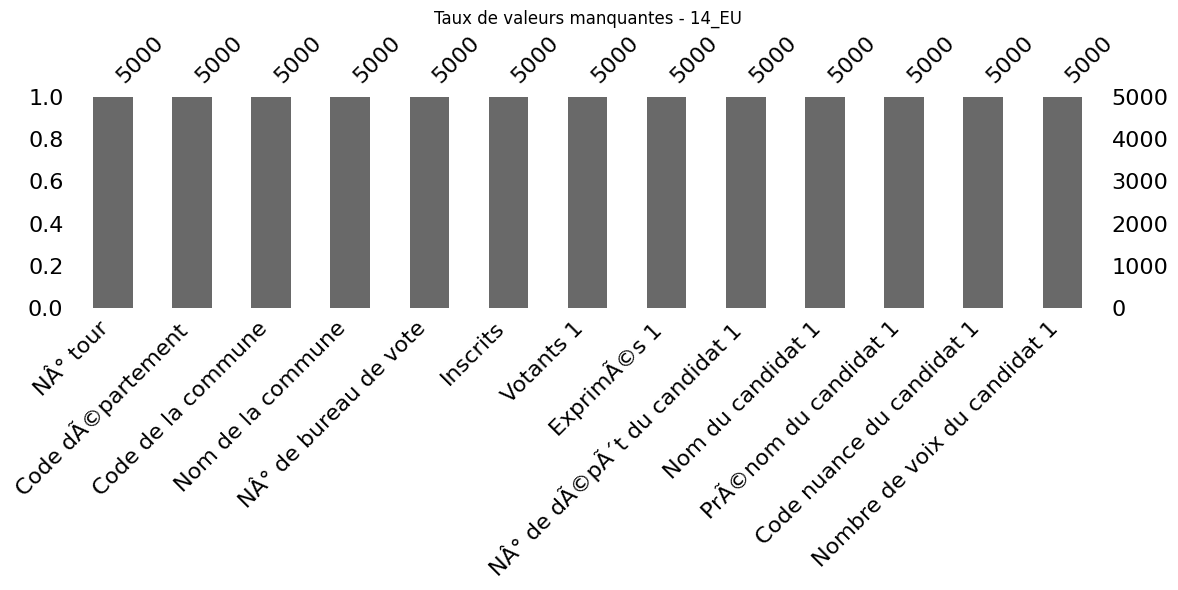

In [14]:
# Visualisation des valeurs manquantes avec missingno
if not dataframes:
    print("Aucun dataframe à visualiser.")
else:
    dataset_to_plot = next(iter(dataframes))
    df_plot = dataframes[dataset_to_plot]
    sample_size = 5000
    df_sample = (
        df_plot.sample(n=sample_size, random_state=42)
        if len(df_plot) > sample_size
        else df_plot
    )
    if df_sample.shape[1] > 40:
        df_sample = df_sample.iloc[:, :40]
        print("Affichage limité aux 40 premières colonnes pour conserver la lisibilité.")

    print(
        f"Valeurs manquantes pour {dataset_to_plot} "
        f"({len(df_sample)} lignes sur {len(df_plot)})"
    )
    ax = msno.bar(df_sample, figsize=(12, 6))
    ax.set_title(f"Taux de valeurs manquantes - {dataset_to_plot}")
    plt.tight_layout()
    plt.show()


In [15]:
EU_14 = pd.read_csv('../data/raw/14_EU.csv', sep=';')
EU_14.shape

MN_14 = pd.read_csv('../data/raw/14_MN14_T1T2.csv', sep=';')
MN_14.shape

/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_18250/2524016337.py:1: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  EU_14 = pd.read_csv('../data/raw/14_EU.csv', sep=';')
/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_18250/2524016337.py:4: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  MN_14 = pd.read_csv('../data/raw/14_MN14_T1T2.csv', sep=';')


(692029, 13)

In [16]:
colonnes_comparatif = pd.read_csv('../reports/colonnes_comparatif.csv')
colonnes_comparatif.head()

,colonne,14_EU,14_MN14_T1T2,17_L_T1,17_L_T2,17_PR_T1,17_PR_T2,19_EU,20_MN_T1,20_MN_T2,...,21_DEP_T2,21_REG_T1,21_REG_T2,22_L_T1,22_L_T2,22_PR_T1,22_PR_T2,24_EU,24_L_T1,24_L_T2
0,% Abs/Ins,NaN,NaN,10.0,10.0,10.0,10.0,8.0,8.0,8.0,...,10.0,9.0,9.0,10.0,10.0,10.0,10.0,NaN,NaN,NaN
1,% Abstentions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,10.0,10.0
2,% Blancs/Ins,NaN,NaN,14.0,14.0,14.0,14.0,12.0,12.0,12.0,...,14.0,13.0,13.0,14.0,14.0,14.0,14.0,NaN,NaN,NaN
3,% Blancs/Vot,NaN,NaN,15.0,15.0,15.0,15.0,13.0,13.0,13.0,...,15.0,14.0,14.0,15.0,15.0,15.0,15.0,NaN,NaN,NaN
4,% Blancs/inscrits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,15.0,15.0


In [17]:
#24_EU	24_L_T1	24_L_T2

Harmoniser les tableaux 24_EU, 24_L_T1 et 24_L_T2 en modifiant les noms de colonnes :

Modifier % Abstentions pour donner le nom % Abs/Ins (comme 17_L_T1)
Modifier % Blancs/inscrits Pour donner le nom % Blancs/Ins (comme 17_L_T1)
Modifier % Blancs/votants Pour donner le nom % Blancs/Vot (comme 17_L_T1)
Modifier % ExprimÃ©s/inscrits pour donner le nom % Exp/Ins (comme 17_L_T1)
Modifier % ExprimÃ©s/votants pour donner le nom % Exp/Vot (comme 17_L_T1)
Modifier % Nuls/inscrits pour donner le nom % Nuls/Ins (comme 17_L_T1)
Modifier % Nuls/votants pour donner le nom % Nuls/Vot (comme 17_L_T1)

Harmoniser dans les tableaux 20_MN_T1, 24_EU, 24_L_T1 et 24_L_T2 quand il est écrit 

% Voix/Exp.X (par exemple % Voix/Exp.1 dans 20_MN_T1) ou % Voix/exprimÃ©s X (par exemple % Voix/exprimÃ©s 1 dans 24_EU, 24_L_T1 et 24_L_T2), il faut écrire % Voix/Exp X (par exemple % Voix/Exp 1) et ainsi de suite pour les différents chiffres.

Idem pour % Voix/Ins.1 et % Voix/inscrits 1 -> % Voix/Ins 1
Idem pour Code Nuance.1 -> Code Nuance 1
Idem pour Code du dÃ©partement, Code du dï¿½partement, Code dÃ©partement, Code département -> Code du département
Idem pour Nom Tï¿½te de Liste 1 -> Nom Tête de Liste 1
Idem pour Nuance Liste 1, Nuance candidat 1, Nuance liste 1 -> Nuance 1
Idem pour PrÃ©nom candidat 1, Prï¿½nom du candidat 1, Pr�nom du candidat  t�te de liste, Prï¿½nom 1 -> Prénom 1
Idem pour Sexe candidat 1, Sexe.1 -> Sexe 1
Idem pour Voix.1 -> Voix 1

